In [1]:
import json
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import ast

ROOT_dir = Path('/Users/jliu/workspace/RAG')

In [ ]:


def find_transition_point(
    log_ranks: np.ndarray,
    log_vals: np.ndarray,
    window_size: int = 50,
    threshold_multiplier: float = 2.0,
    min_rank_percentile: float = 0.05,
    max_rank_percentile: float = 1.0,
    expected_direction: str = "any",  # "positive", "negative", or "any"
    min_log_rank: float = None,
    max_log_rank: float = None,
) -> dict:
    """
    Find a transition point using second derivative analysis with constraints.
    
    Parameters:
    -----------
    log_ranks: log-rank values
    log_vals: log-value data points
    window_size: window for calculating local slopes
    threshold_multiplier: sensitivity for detecting significant changes
    min_rank_percentile: minimum percentile to start analysis
    max_rank_percentile: maximum percentile to end analysis
    expected_direction: expected direction of second derivative ("positive", "negative", or "any")
    min_log_rank: minimum log rank to consider (direct constraint)
    max_log_rank: maximum log rank to consider (direct constraint)
    
    Returns:
    --------
    Dictionary with transition point information
    """
    n = len(log_ranks)
    info = {"transition_detected": False}
    
    # Apply rank percentile constraints
    min_idx = max(int(n * min_rank_percentile), window_size)
    max_idx = min(int(n * max_rank_percentile), n - window_size)
    
    # Apply direct log rank constraints if provided
    if min_log_rank is not None:
        min_rank_idx = np.where(log_ranks >= min_log_rank)[0]
        if len(min_rank_idx) > 0:
            min_idx = max(min_idx, min_rank_idx[0])
    
    if max_log_rank is not None:
        max_rank_idx = np.where(log_ranks <= max_log_rank)[0]
        if len(max_rank_idx) > 0:
            max_idx = min(max_idx, max_rank_idx[-1])
    
    # Ensure we have enough data points
    if max_idx <= min_idx + window_size:
        return info
    
    # Dynamic window size
    w = min(window_size, max(5, (max_idx - min_idx) // 5))
    
    # Calculate first derivatives (slopes)
    derivatives, idxs = [], []
    for i in range(min_idx, max_idx - w + 1):
        slope, _, _, _, _ = stats.linregress(
            log_ranks[i : i + w], log_vals[i : i + w]
        )
        derivatives.append(slope)
        idxs.append(i)
    
    derivatives = np.array(derivatives)
    
    # Calculate second derivatives (changes in slope)
    if len(derivatives) > 1:
        second_derivatives = np.diff(derivatives)
        
        # Apply direction constraint if specified
        if expected_direction == "positive":
            second_derivatives[second_derivatives <= 0] = 0
        elif expected_direction == "negative":
            second_derivatives[second_derivatives >= 0] = 0
        
        # Find significant changes
        abs_second_derivatives = np.abs(second_derivatives)
        threshold = np.mean(abs_second_derivatives) * threshold_multiplier
        significant_changes = np.where(abs_second_derivatives > threshold)[0]
        
        if len(significant_changes) > 0:
            # Find the most significant change
            max_change_idx = significant_changes[np.argmax(abs_second_derivatives[significant_changes])]
            transition_idx = idxs[max_change_idx + 1]  # +1 because of diff
            
            return {
                "transition_detected": True,
                "method": "second_derivative",
                "index": transition_idx,
                "log_rank": log_ranks[transition_idx],
                "log_value": log_vals[transition_idx],
                "second_derivative": second_derivatives[max_change_idx],
                "sig": abs_second_derivatives[max_change_idx] / threshold
            }
    
    return info

def zipf_and_transitions(values, plateau_params=None, elbow_params=None):
    """
    Analyze the distribution and identify both transition points using a unified approach.
    
    Parameters:
    -----------
    values: Neuron influence values
    plateau_params: Dictionary of parameters for plateau transition detection
    elbow_params: Dictionary of parameters for elbow point detection
    
    Returns:
    --------
    log_ranks, log_vals, zipf_line, coeffs, elbow_info, plateau_info
    """
    arr = np.array(values)
    arr = arr[arr > 0]
    sorted_vals = np.sort(arr)[::-1]
    ranks = np.arange(1, len(sorted_vals)+1)
    log_ranks = np.log(ranks)
    log_vals = np.log(sorted_vals)
    
    # Fit the overall linear model (Zipf)
    coeffs = np.polyfit(log_ranks, log_vals, deg=1)
    zipf_slope = coeffs[0]
    zipf_line = np.poly1d(coeffs)(log_ranks)
    
    # Default parameters for plateau transition
    default_plateau_params = {
        "window_size": 3,
        "threshold_multiplier": 0.3,
        "min_rank_percentile": 0.0,
        "max_rank_percentile": 0.3,
        "expected_direction": "positive",  # Slope becomes more negative (second derivative positive)
        "max_log_rank": 3.0  # Force early detection
    }
    
    # Default parameters for elbow point
    default_elbow_params = {
        "window_size": 20,
        "threshold_multiplier": 2.0,
        "min_rank_percentile": 0.4,
        "max_rank_percentile": 0.85,
        "expected_direction": "negative",  # Slope becomes even more negative (second derivative negative)
        "min_log_rank": 5.5,
        "max_log_rank": 6.5
    }
    
    # Update with provided parameters if any
    if plateau_params is not None:
        default_plateau_params.update(plateau_params)
    
    if elbow_params is not None:
        default_elbow_params.update(elbow_params)
    
    # Find the plateau transition
    plateau_info = find_transition_point(log_ranks, log_vals, **default_plateau_params)
    
    # Rename for clarity
    if plateau_info["transition_detected"]:
        plateau_info["plateau_detected"] = plateau_info.pop("transition_detected")
    else:
        plateau_info["plateau_detected"] = False
    
    # Find the elbow point
    elbow_info = find_transition_point(log_ranks, log_vals, **default_elbow_params)
    
    # Rename for clarity
    if elbow_info["transition_detected"]:
        elbow_info["elbow_detected"] = elbow_info.pop("transition_detected")
    else:
        elbow_info["elbow_detected"] = False
    
    # Ensure elbow comes after plateau if both are detected
    if (plateau_info["plateau_detected"] and elbow_info["elbow_detected"] and 
        plateau_info["index"] >= elbow_info["index"]):
        # Constrain elbow search to be after plateau
        default_elbow_params["min_rank_percentile"] = plateau_info["index"] / len(log_ranks) + 0.05
        elbow_info = find_transition_point(log_ranks, log_vals, **default_elbow_params)
        
        if elbow_info["transition_detected"]:
            elbow_info["elbow_detected"] = elbow_info.pop("transition_detected")
        else:
            elbow_info["elbow_detected"] = False
    
    return log_ranks, log_vals, zipf_line, coeffs, elbow_info, plateau_info

def calculate_phase_metrics(log_ranks, log_vals, zipf_line, plateau_info, elbow_info):
    """Calculate metrics for each phase."""
    metrics = {}
    
    if plateau_info.get("plateau_detected") and elbow_info.get("elbow_detected"):
        # Get the indices for each phase boundary
        plateau_idx = plateau_info["index"]
        elbow_idx = elbow_info["index"]
        
        # Define the three phases
        plateau_mask = np.arange(len(log_ranks)) < plateau_idx
        linear_mask = (np.arange(len(log_ranks)) >= plateau_idx) & (np.arange(len(log_ranks)) < elbow_idx)
        fast_decay_mask = np.arange(len(log_ranks)) >= elbow_idx
        
        # Calculate metrics for each phase
        
        # 1. Phase sizes (number of neurons)
        metrics["plateau_size"] = np.sum(plateau_mask)
        metrics["linear_size"] = np.sum(linear_mask)
        metrics["fast_decay_size"] = np.sum(fast_decay_mask)
        
        # 2. Phase percentages
        total = len(log_ranks)
        metrics["plateau_percent"] = 100 * metrics["plateau_size"] / total
        metrics["linear_percent"] = 100 * metrics["linear_size"] / total
        metrics["fast_decay_percent"] = 100 * metrics["fast_decay_size"] / total
        
        # 3. Area metrics (deviation from linear fit)
        # Area above linear for plateau phase
        if np.any(plateau_mask):
            metrics["plateau_area"] = np.sum(log_vals[plateau_mask] - zipf_line[plateau_mask])
        else:
            metrics["plateau_area"] = 0
            
        # Area below linear for fast decay phase
        if np.any(fast_decay_mask):
            metrics["fast_decay_area"] = np.sum(zipf_line[fast_decay_mask] - log_vals[fast_decay_mask])
        else:
            metrics["fast_decay_area"] = 0
        
        # 4. Average slopes in each phase
        if np.sum(plateau_mask) >= 2:
            plateau_slope, _, _, _, _ = stats.linregress(
                log_ranks[plateau_mask], log_vals[plateau_mask]
            )
            metrics["plateau_slope"] = plateau_slope
        else:
            metrics["plateau_slope"] = None
            
        if np.sum(linear_mask) >= 2:
            linear_slope, _, _, _, _ = stats.linregress(
                log_ranks[linear_mask], log_vals[linear_mask]
            )
            metrics["linear_slope"] = linear_slope
        else:
            metrics["linear_slope"] = None
            
        if np.sum(fast_decay_mask) >= 2:
            fast_decay_slope, _, _, _, _ = stats.linregress(
                log_ranks[fast_decay_mask], log_vals[fast_decay_mask]
            )
            metrics["fast_decay_slope"] = fast_decay_slope
        else:
            metrics["fast_decay_slope"] = None
        
        # 5. Second derivative magnitudes at transition points
        if "second_derivative" in plateau_info:
            metrics["plateau_transition_magnitude"] = plateau_info["second_derivative"]
            metrics["plateau_transition_sig"] = plateau_info.get("sig", 0)
            
        if "second_derivative" in elbow_info:
            metrics["elbow_transition_magnitude"] = elbow_info["second_derivative"]
            metrics["elbow_transition_sig"] = elbow_info.get("sig", 0)
    
    return metrics

def plot_zipf_elbow(
    log_ranks, log_vals, zipf_line, coeffs, elbow_info, plateau_info, 
    title: str, save_path: Path, ylim: tuple = None
):
    """
    Create visualization with all three phases identified and metrics displayed.
    
    Parameters:
    -----------
    log_ranks: Log-rank values
    log_vals: Log-value data points
    zipf_line: Fitted Zipf line
    coeffs: Fit coefficients
    elbow_info: Elbow point detection results
    plateau_info: Plateau transition detection results
    title: Plot title
    save_path: Path to save the figure
    ylim: Y-axis limits (min, max) to unify plots
    """
    plt.figure(figsize=(6, 4))
    plt.plot(log_ranks, log_vals, '.', alpha=0.6)
    plt.plot(log_ranks, zipf_line, 'r-', linewidth=1.5)
    
    # Initialize text box
    box_text = [f"Slope fit: {coeffs[0]:.2f}"]
    
    # Calculate phase metrics if both transitions detected
    if elbow_info.get("elbow_detected") and plateau_info.get("plateau_detected"):
        metrics = calculate_phase_metrics(log_ranks, log_vals, zipf_line, plateau_info, elbow_info)
        
        # Add shaded regions for the three phases
        plt.axvspan(min(log_ranks), plateau_info["log_rank"], alpha=0.1, color='blue')
        plt.axvspan(plateau_info["log_rank"], elbow_info["log_rank"], alpha=0.1, color='green')
        plt.axvspan(elbow_info["log_rank"], max(log_ranks), alpha=0.1, color='red')
        
        # Add key metrics to text box
        if "plateau_area" in metrics:
            box_text.append(f"Plateau area: {metrics['plateau_area']:.2f}")
        if "plateau_transition_sig" in metrics:
            box_text.append(f"Plateau sig: {metrics['plateau_transition_sig']:.2f}")
        if "fast_decay_area" in metrics:
            box_text.append(f"Fast decay area: {metrics['fast_decay_area']:.2f}")
        if "elbow_transition_sig" in metrics:
            box_text.append(f"Elbow sig: {metrics['elbow_transition_sig']:.2f}")
    
    # Mark the plateau transition
    if plateau_info.get("plateau_detected"):
        lr_plateau = plateau_info["log_rank"]
        lv_plateau = plateau_info["log_value"]
        idx_plateau = plateau_info["index"]
        
        # Mark the point
        plt.scatter(lr_plateau, lv_plateau, c='blue', marker='D', s=100)
        
        # Draw horizontal line to y-axis instead of vertical line
        plt.hlines(lv_plateau, xmin=min(log_ranks), xmax=lr_plateau,
                 colors='blue', linestyles='--')
        
        box_text.append(f"Plateau@rank={idx_plateau}")
    else:
        box_text.append("!NO Plateau Detected")
    
    # Mark the elbow point
    if elbow_info.get("elbow_detected"):
        lr_elbow = elbow_info["log_rank"]
        lv_elbow = elbow_info["log_value"]
        idx_elbow = elbow_info["index"]
        mtd_elbow = elbow_info.get("method", "")
        
        # Mark the point
        plt.scatter(lr_elbow, lv_elbow, c='green', marker='X', s=100)
        
        # Draw horizontal line to y-axis instead of vertical line
        plt.hlines(lv_elbow, xmin=min(log_ranks), xmax=lr_elbow,
                 colors='green', linestyles='--')
        
        box_text.append(f"Elbow@rank={idx_elbow}")
    else:
        box_text.append("!NO Elbow Point")
    
    # Add text box with metrics in upper right corner
    plt.gca().text(
        0.95, 0.95, "\n".join(box_text),
        transform=plt.gca().transAxes,
        fontsize=9, va='top', ha='right',
        bbox=dict(boxstyle="round,pad=0.3", fc="wheat", ec="gray", lw=0.8)
    )
    
    # Set y-axis limits if provided
    if ylim is not None:
        plt.ylim(ylim)
    
    plt.title(title)
    plt.xlabel("Log Rank")
    plt.ylabel("Log Value")
    #plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)

def run_analysis(
    root_dir: str, 
    output_dir: str, 
    save_metrics: bool = True,
    plateau_params: dict = None,
    elbow_params: dict = None,
    ylim: tuple = None
):
    """
    Batch process all 500_all.csv files in the directory,
    perform Zipf analysis with unified second-derivative transition detection,
    and save results to output_dir.
    
    Parameters:
    -----------
    root_dir: Directory containing CSV files with neuron influence data
    output_dir: Directory to save plots and metrics
    save_metrics: Whether to save phase metrics to JSON files
    plateau_params: Dictionary of parameters for plateau transition detection
    elbow_params: Dictionary of parameters for elbow point detection
    ylim: Y-axis limits (min, max) to unify plots
    """
    root_path = Path(root_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Create a metrics directory if saving metrics
    if save_metrics:
        metrics_path = output_path / "metrics"
        metrics_path.mkdir(exist_ok=True)
    
    # Find all CSV files
    csv_files = list(root_path.rglob("500_all.csv"))
    
    # Track metrics across all files for summary analysis
    all_metrics = []
    
    # Default plateau params if not provided
    if plateau_params is None:
        plateau_params = {
            "window_size": 3,
            "threshold_multiplier": 0.3,
            "min_rank_percentile": 0.0,
            "max_rank_percentile": 0.3,
            "expected_direction": "positive",
            "max_log_rank": 3.0
        }
    
    # Default elbow params if not provided
    if elbow_params is None:
        elbow_params = {
            "window_size": 20,
            "threshold_multiplier": 2.0,
            "min_rank_percentile": 0.4,
            "max_rank_percentile": 0.85,
            "expected_direction": "negative",
            "min_log_rank": 5.5,
            "max_log_rank": 6.5
        }
    
    for csv_file in csv_files:
        # Read and preprocess the CSV
        df = pd.read_csv(csv_file)
        df["abs_delta_loss_post_ablation"] = df["abs_delta_loss_post_ablation"].apply(ast.literal_eval)
        df["step"] = df["step"].astype(str)
        rel_id = str(csv_file.relative_to(root_path).parent).replace("/", "_")
        
        # Dictionary to store metrics for this file
        file_metrics = {"file_id": rel_id, "steps": []}
        
        # Analyze each training step
        for _, row in df.iterrows():
            step = row["step"]
            vals = row["abs_delta_loss_post_ablation"]
            
            # Apply the unified approach with custom parameters
            lr, lv, zl, coeffs, elbow_info, plateau_info = zipf_and_transitions(
                vals,
                plateau_params=plateau_params,
                elbow_params=elbow_params
            )
            
            # Generate and save the plot
            title = f"[{rel_id}] Step {step}"
            save_p = output_path / f"{rel_id}_step{step}_zipf_transitions.png"
            plot_zipf_elbow(lr, lv, zl, coeffs, elbow_info, plateau_info, title, save_p, ylim=ylim)
            
            # Calculate and store metrics if both transitions are detected
            if plateau_info.get("plateau_detected") and elbow_info.get("elbow_detected"):
                metrics = calculate_phase_metrics(lr, lv, zl, plateau_info, elbow_info)
                
                # Add step information
                step_metrics = {
                    "step": step,
                    "zipf_slope": coeffs[0],
                    "plateau_rank": int(plateau_info["index"]),
                    "plateau_log_rank": float(plateau_info["log_rank"]),
                    "elbow_rank": int(elbow_info["index"]),
                    "elbow_log_rank": float(elbow_info["log_rank"]),
                    **metrics
                }
                
                # Add to file metrics
                file_metrics["steps"].append(step_metrics)
                
                # Add to all metrics with file identifier
                all_metrics.append({
                    "file_id": rel_id,
                    "step": step,
                    **step_metrics
                })
        
        """
        # Save metrics for this file if requested
        if save_metrics and file_metrics["steps"]:
            metrics_file = metrics_path / f"{rel_id}_metrics.json"
            with open(metrics_file, 'w') as f:
                json.dump(file_metrics, f, indent=2)
        """
    return file_metrics
    
    # Create a summary plot of transitions across training steps if we have enough data
    #if len(all_metrics) > 1:
        #create_transition_summary(all_metrics, output_path)
    
    #plt.close('all')  # Close any remaining plots

def create_transition_summary(metrics_list, output_path):
    """Create summary visualizations of phase transitions across training steps."""
    # Convert to DataFrame for easier analysis
    metrics_df = pd.DataFrame(metrics_list)
    
    # Group by file_id to analyze each model separately
    for file_id, group in metrics_df.groupby('file_id'):
        if len(group) < 2:  # Skip if not enough data points
            continue
        
        # Sort by step for proper ordering
        group = group.sort_values('step')
        steps = group['step'].astype(int).values
        
        # Create figure with multiple subplots
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))
        
        # Plot 1: Transition ranks over training steps
        axs[0, 0].plot(steps, group['plateau_rank'], 'b-o', label='Plateau Transition')
        axs[0, 0].plot(steps, group['elbow_rank'], 'g-x', label='Elbow Point')
        axs[0, 0].set_xlabel('Training Step')
        axs[0, 0].set_ylabel('Rank')
        axs[0, 0].set_title('Transition Points by Rank')
    
        
        # Plot 2: Phase sizes as percentages
        axs[0, 1].stackplot(steps, 
                           group['plateau_percent'].values,
                           group['linear_percent'].values, 
                           group['fast_decay_percent'].values,
                           labels=['Plateau', 'Linear', 'Fast Decay'],
                           colors=['blue', 'green', 'red'], alpha=0.7)
        axs[0, 1].set_xlabel('Training Step')
        axs[0, 1].set_ylabel('Percentage')
        axs[0, 1].set_title('Phase Size Distribution')
        #axs[0, 1].legend()
        
        # Plot 3: Area metrics over training steps
        axs[1, 0].plot(steps, group['plateau_area'], 'b-o', label='Plateau Area')
        axs[1, 0].plot(steps, group['fast_decay_area'], 'r-x', label='Fast Decay Area')
        axs[1, 0].set_xlabel('Training Step')
        axs[1, 0].set_ylabel('Area')
        axs[1, 0].set_title('Phase Deviation Areas')
        #axs[1, 0].legend()
        
        # Plot 4: Slopes within each phase
        if 'plateau_slope' in group.columns and 'linear_slope' in group.columns and 'fast_decay_slope' in group.columns:
            # Convert any None values to NaN for plotting
            plateau_slopes = pd.Series(group['plateau_slope'].values).replace({None: np.nan})
            linear_slopes = pd.Series(group['linear_slope'].values).replace({None: np.nan})
            fast_decay_slopes = pd.Series(group['fast_decay_slope'].values).replace({None: np.nan})
            
            axs[1, 1].plot(steps, plateau_slopes, 'b-o', label='Plateau Slope')
            axs[1, 1].plot(steps, linear_slopes, 'g-s', label='Linear Slope')
            axs[1, 1].plot(steps, fast_decay_slopes, 'r-x', label='Fast Decay Slope')
            axs[1, 1].set_xlabel('Training Step')
            axs[1, 1].set_ylabel('Slope')
            axs[1, 1].set_title('Phase Slopes')
            #axs[1, 1].legend()
        
        plt.tight_layout()
        plt.savefig(output_path / f"{file_id}_phase_transitions_summary.png", dpi=300)
        plt.close()



In [4]:
## 更新的加入count的函数
def plot_zipf_elbow(
    log_ranks, log_vals, zipf_line, coeffs, elbow_info, plateau_info, 
    title: str, save_path: Path, ylim: tuple = None
):
    """
    Create visualization with all three phases identified and metrics displayed.
    
    Parameters:
    -----------
    log_ranks: Log-rank values
    log_vals: Log-value data points
    zipf_line: Fitted Zipf line
    coeffs: Fit coefficients
    elbow_info: Dictionary with elbow transition information
    plateau_info: Dictionary with plateau transition information
    title: Plot title
    save_path: Path to save the visualization
    ylim: Optional y-axis limits (min, max)
    """
    plt.figure(figsize=(12, 8))
    
    # Plot the data and Zipf fit
    plt.plot(log_ranks, log_vals, '.', alpha=0.6)
    plt.plot(log_ranks, zipf_line, 'r-', linewidth=1.5)
    
    # Initialize text box
    box_text = [f"Slope fit: {coeffs[0]:.2f}"]
    
    # Calculate phase metrics if both transitions detected
    if elbow_info.get("elbow_detected") and plateau_info.get("plateau_detected"):
        metrics = calculate_phase_metrics(log_ranks, log_vals, zipf_line, plateau_info, elbow_info)
        
        # Add shaded regions for the three phases
        plt.axvspan(min(log_ranks), plateau_info["log_rank"], alpha=0.1, color='blue')
        plt.axvspan(plateau_info["log_rank"], elbow_info["log_rank"], alpha=0.1, color='green')
        plt.axvspan(elbow_info["log_rank"], max(log_ranks), alpha=0.1, color='red')
        
        # 获取一个底部的 y 值，略微低于 min(log_vals) 但不出图
        bottom_y = min(log_vals) - (max(log_vals) - min(log_vals)) * 0.05

        # 显示在底部
        plt.text(min(log_ranks) + (plateau_info["log_rank"] - min(log_ranks))/2, 
                 bottom_y, 
                 f"{metrics['plateau_size']} neurons", 
                 ha='center', va='top', color='blue', fontweight='bold')

        plt.text(plateau_info["log_rank"] + (elbow_info["log_rank"] - plateau_info["log_rank"])/2, 
                 bottom_y, 
                 f"{metrics['linear_size']} neurons", 
                 ha='center', va='top', color='green', fontweight='bold')

        plt.text(elbow_info["log_rank"] + (max(log_ranks) - elbow_info["log_rank"])/2, 
                 bottom_y, 
                 f"{metrics['fast_decay_size']} neurons", 
                 ha='center', va='top', color='red', fontweight='bold')

        
        # Add key metrics to text box
        if "plateau_area" in metrics:
            box_text.append(f"Plateau/Blue: {metrics['plateau_size']} neurons ({metrics['plateau_percent']:.1f}%)")
            box_text.append(f"Linear/Green: {metrics['linear_size']} neurons ({metrics['linear_percent']:.1f}%)")
            box_text.append(f"Fast decay/Red: {metrics['fast_decay_size']} neurons ({metrics['fast_decay_percent']:.1f}%)")
            box_text.append(f"Plateau area: {metrics['plateau_area']:.1f}")
            box_text.append(f"Fast decay area: {metrics['fast_decay_area']:.1f}")
            
            if metrics["plateau_slope"] is not None:
                box_text.append(f"Plateau slope: {metrics['plateau_slope']:.2f}")
                
            if metrics["linear_slope"] is not None:
                box_text.append(f"Linear slope: {metrics['linear_slope']:.2f}")
                
            if metrics["fast_decay_slope"] is not None:
                box_text.append(f"Fast decay slope: {metrics['fast_decay_slope']:.2f}")
    
    # Mark the plateau transition
    if plateau_info.get("plateau_detected"):
        lr_plateau = plateau_info["log_rank"]
        lv_plateau = plateau_info["log_value"]
        idx_plateau = plateau_info["index"]
        mtd_plateau = plateau_info.get("method", "")
        
        # Mark the point
        plt.scatter(lr_plateau, lv_plateau, c='blue', marker='D', s=100)
        
        # Draw horizontal line to y-axis instead of vertical line
        plt.hlines(lv_plateau, xmin=min(log_ranks), xmax=lr_plateau,
                 colors='blue', linestyles='--')
        
        box_text.append(f"Plateau@rank={idx_plateau}")
    else:
        box_text.append("!NO Plateau Detected")
    
    # Mark the elbow point
    if elbow_info.get("elbow_detected"):
        lr_elbow = elbow_info["log_rank"]
        lv_elbow = elbow_info["log_value"]
        idx_elbow = elbow_info["index"]
        mtd_elbow = elbow_info.get("method", "")
        
        # Mark the point
        plt.scatter(lr_elbow, lv_elbow, c='green', marker='X', s=100)
        
        # Draw horizontal line to mark y-value
        plt.hlines(lv_elbow, xmin=min(log_ranks), xmax=lr_elbow,
                 colors='green', linestyles='--')
        
        box_text.append(f"Elbow@rank={idx_elbow}")
    else:
        box_text.append("!NO Elbow Point")
    
    # Add text box with metrics in upper right corner
    plt.gca().text(
        0.95, 0.95, "\n".join(box_text),
        transform=plt.gca().transAxes,
        fontsize=10,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9)
    )
    
    # Set labels and title
    plt.xlabel('Log Rank')
    plt.ylabel('Log Value')
    plt.title(title)
    
    # Set y-axis limits if provided
    if ylim is not None:
        plt.ylim(ylim)
    
    # Save figure
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_1297/3655914063.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  "sig": abs_second_derivatives[max_change_idx] / threshold


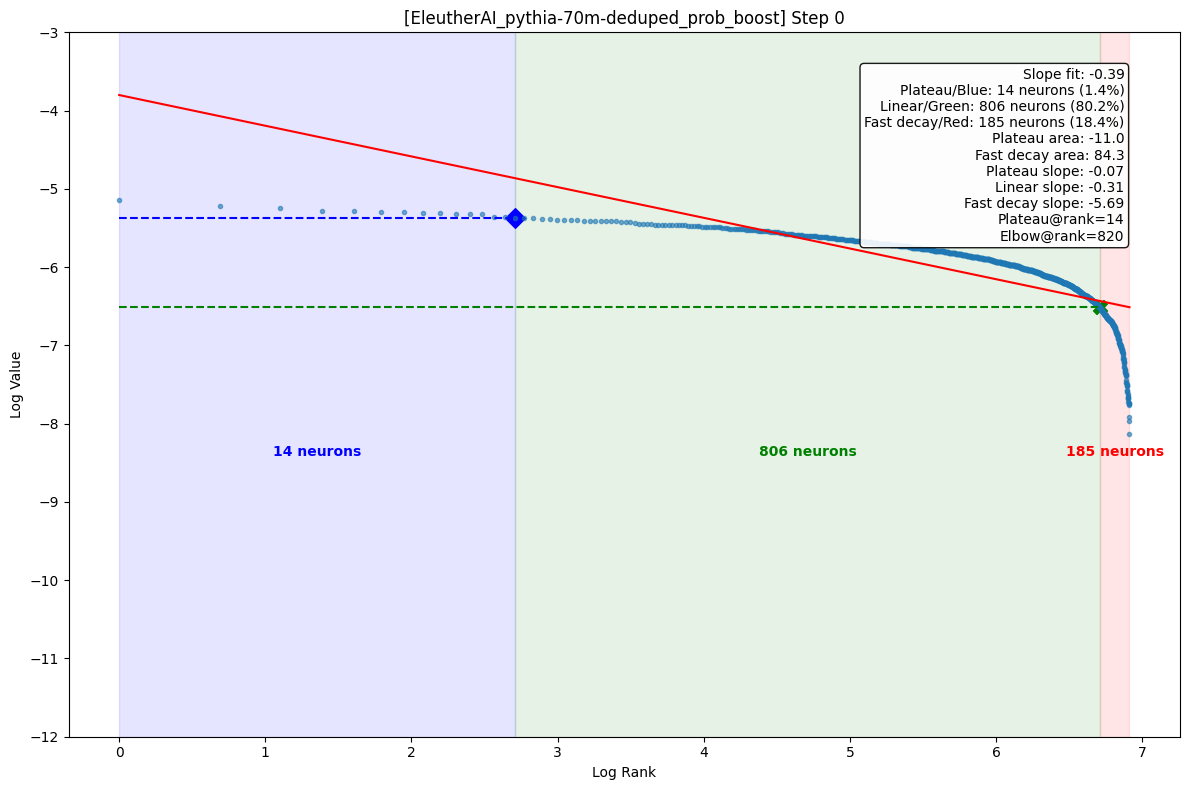

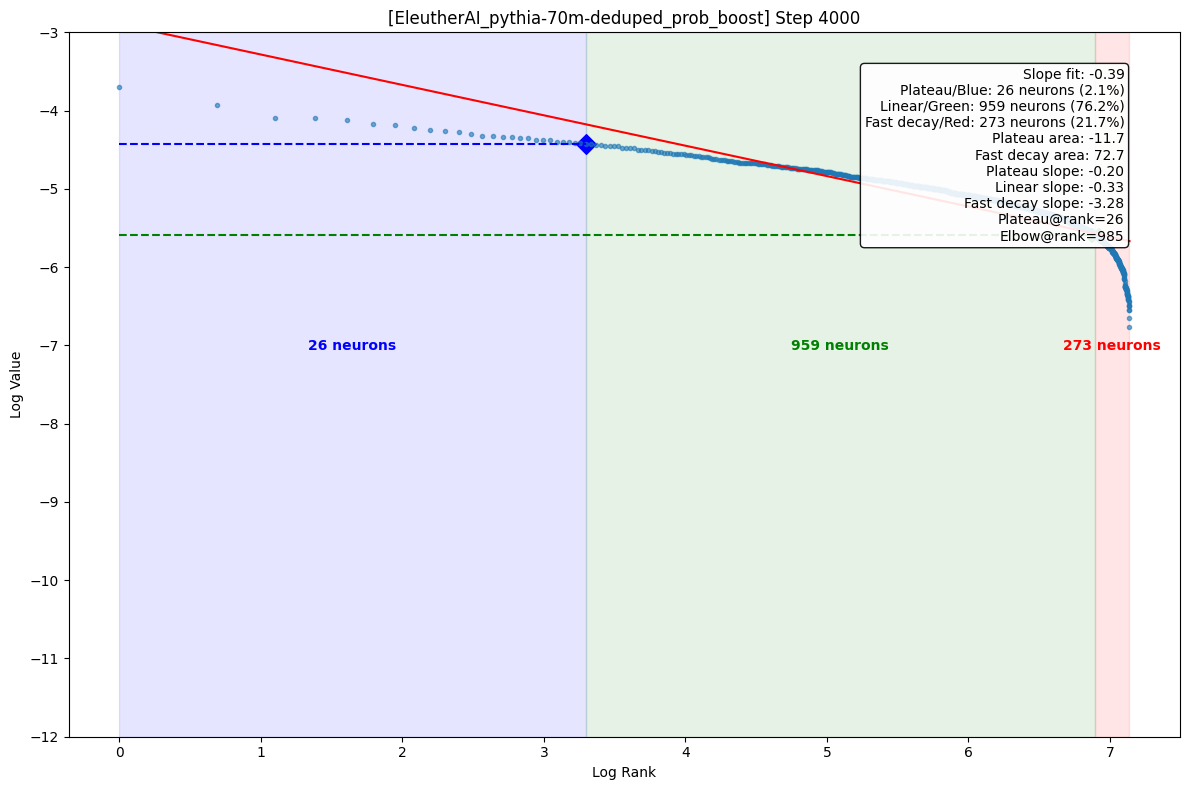

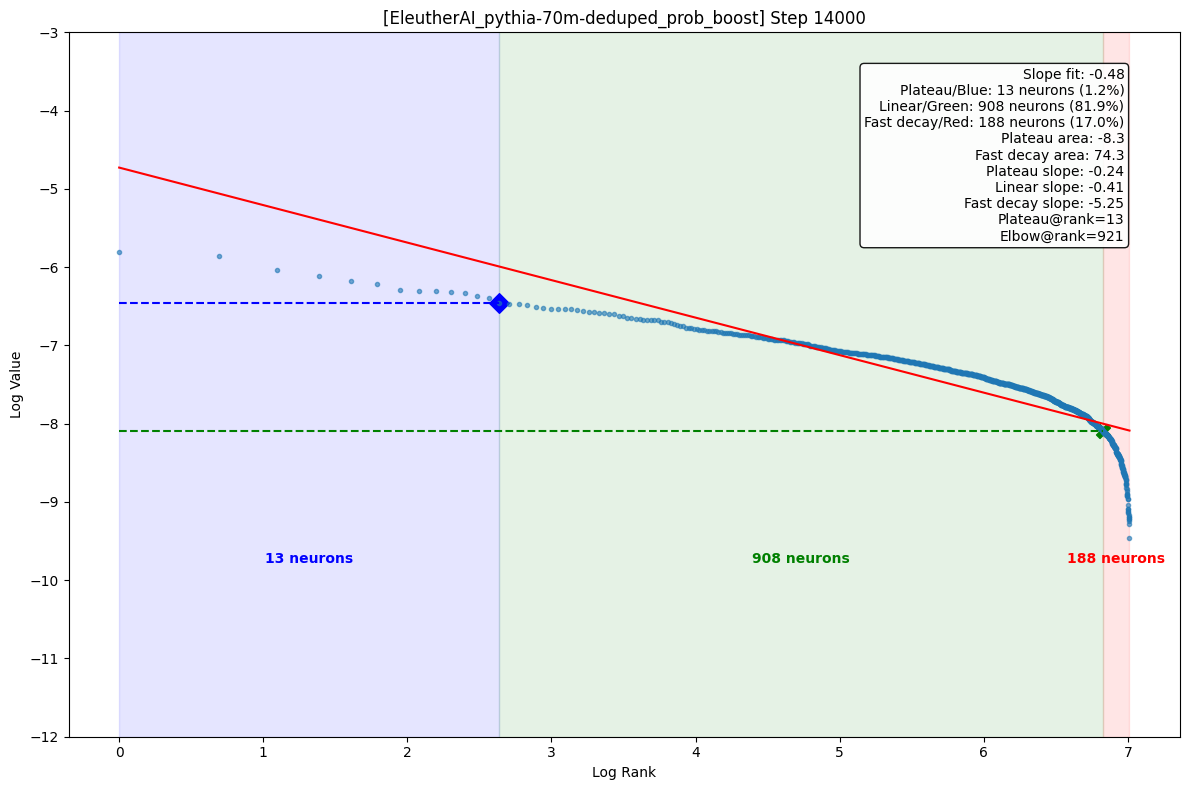

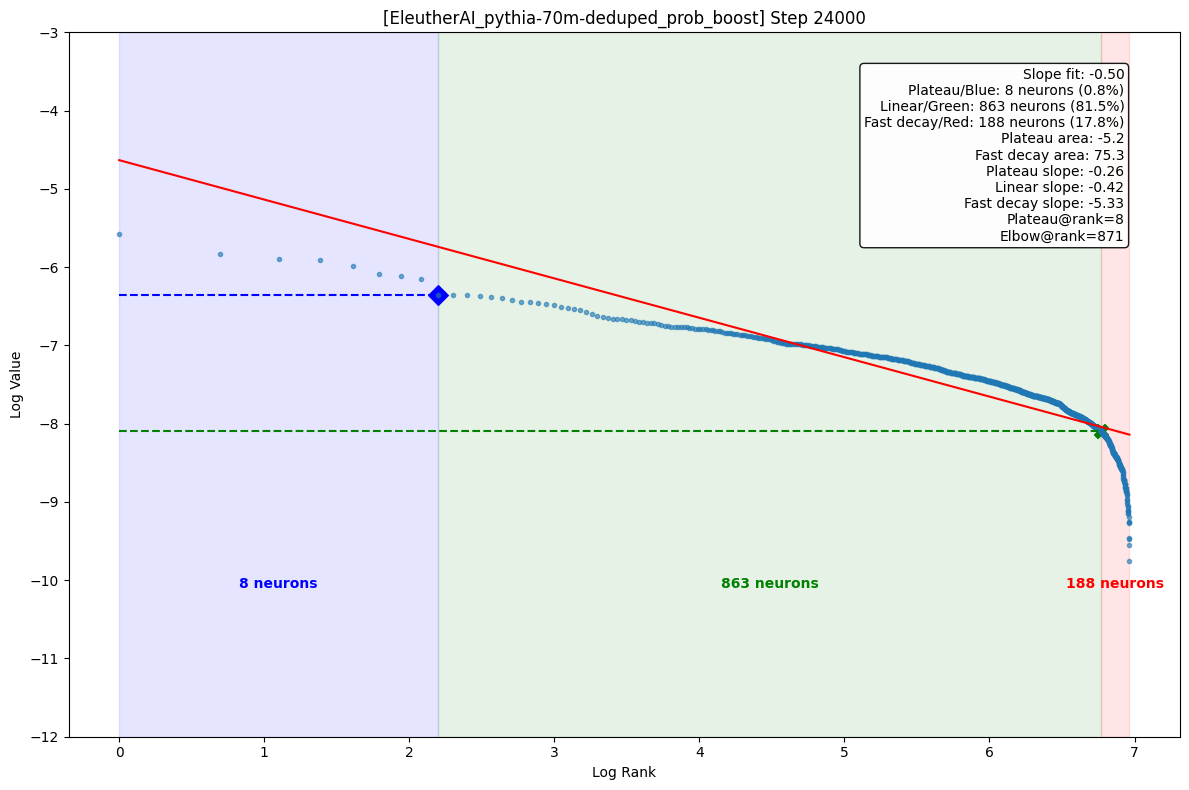

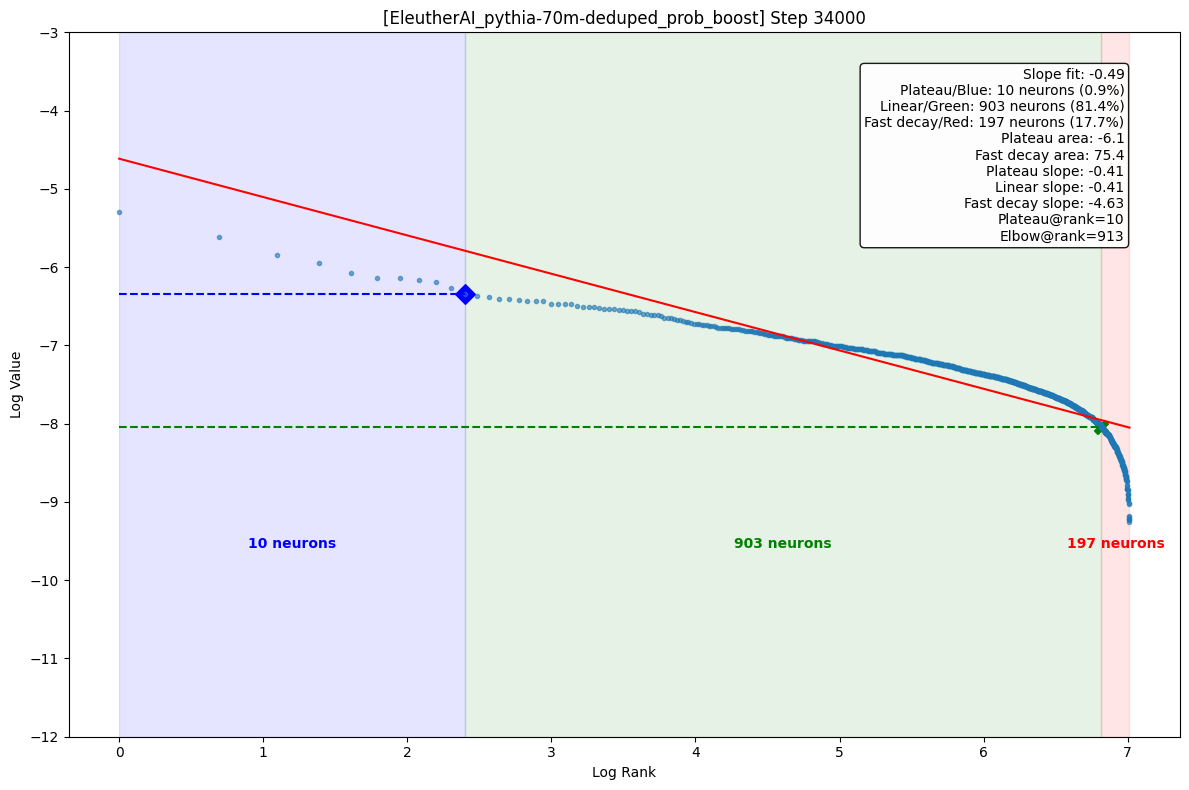

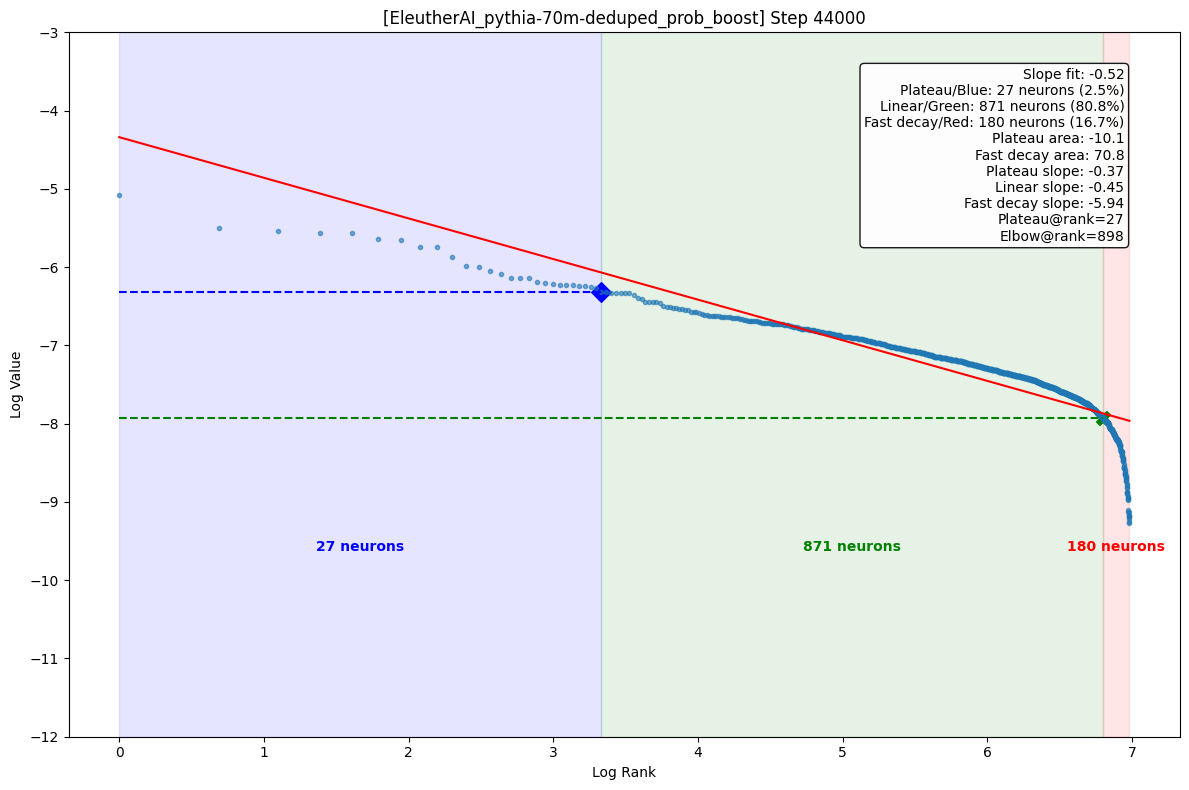

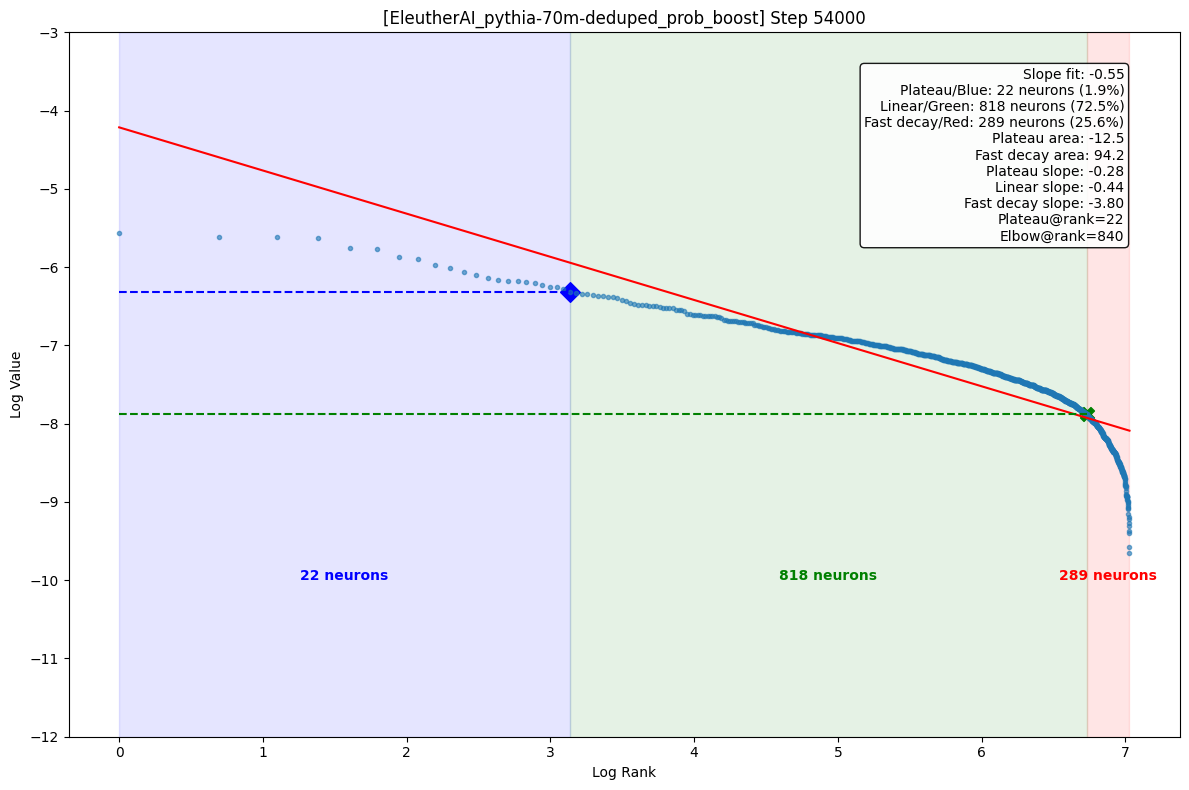

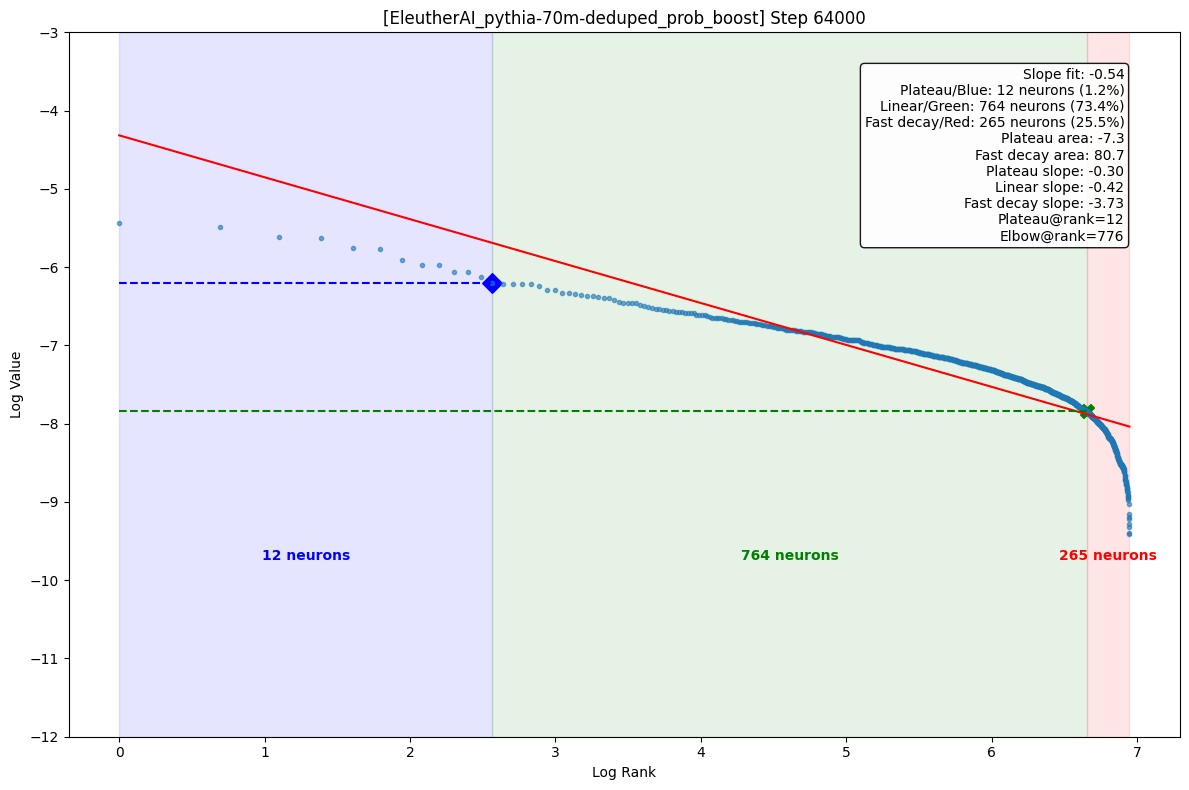

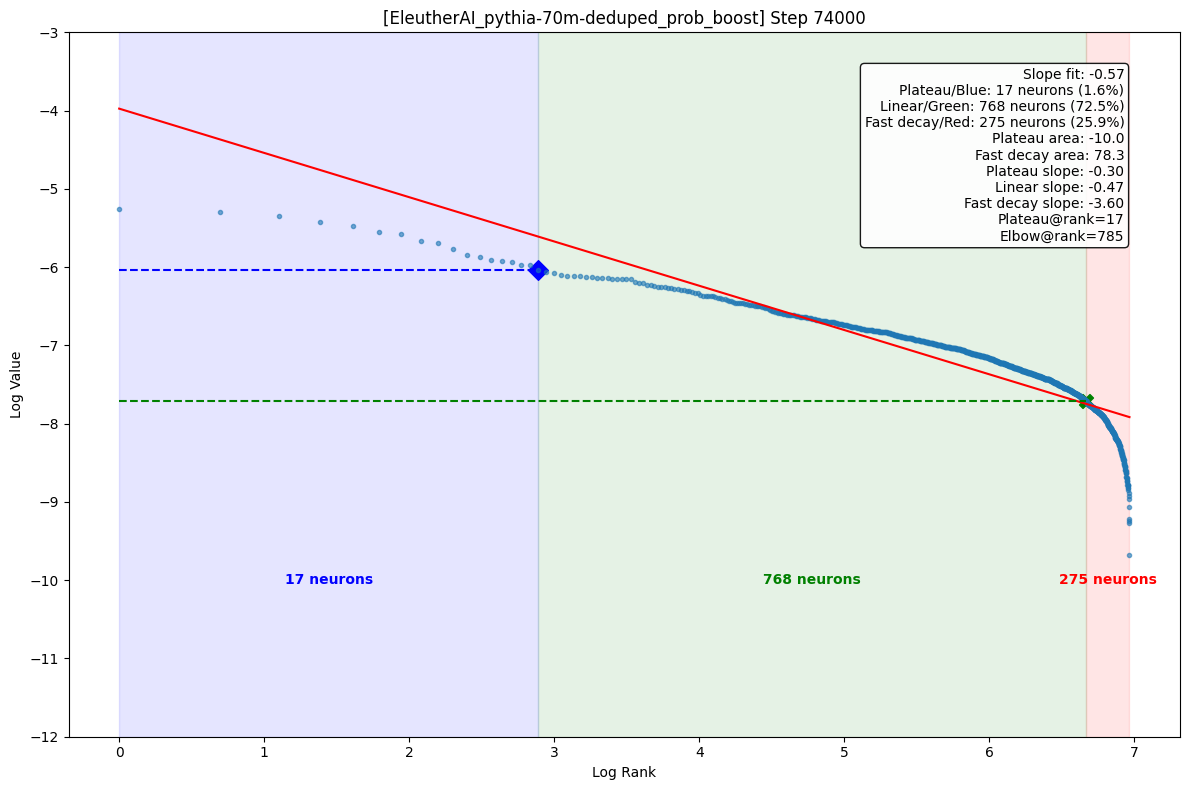

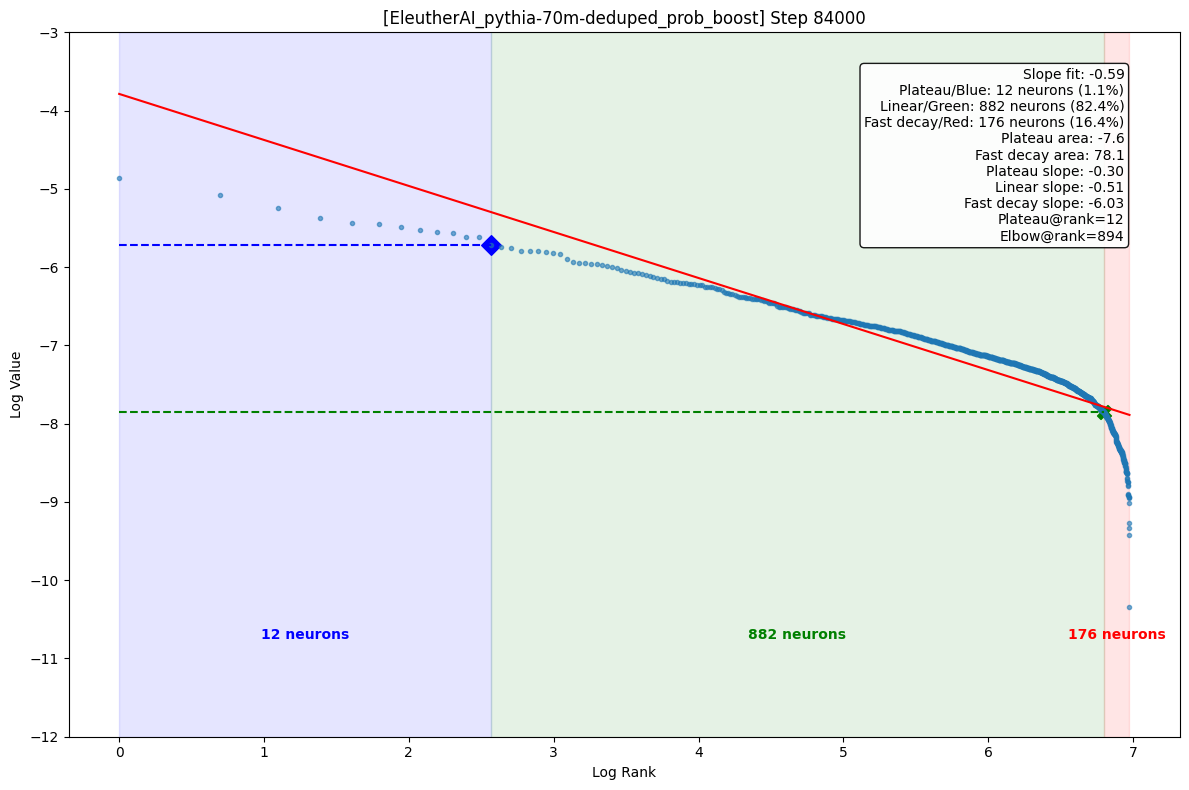

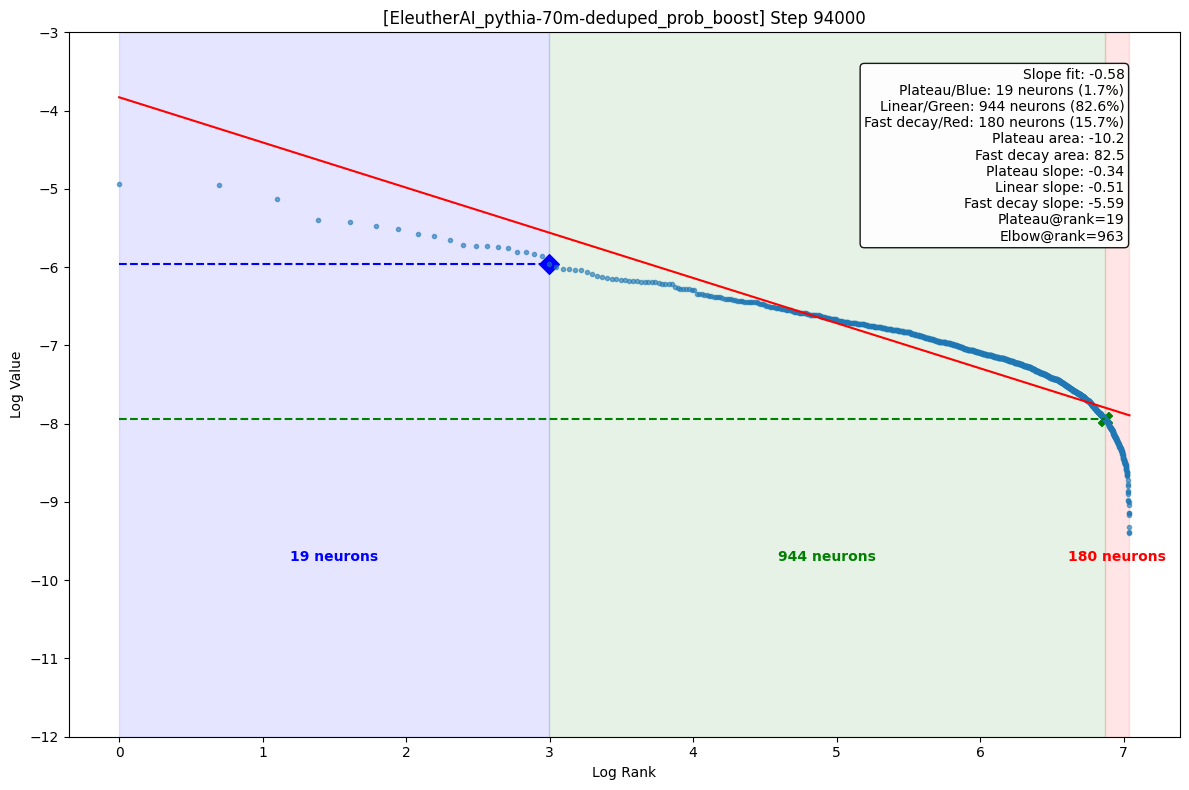

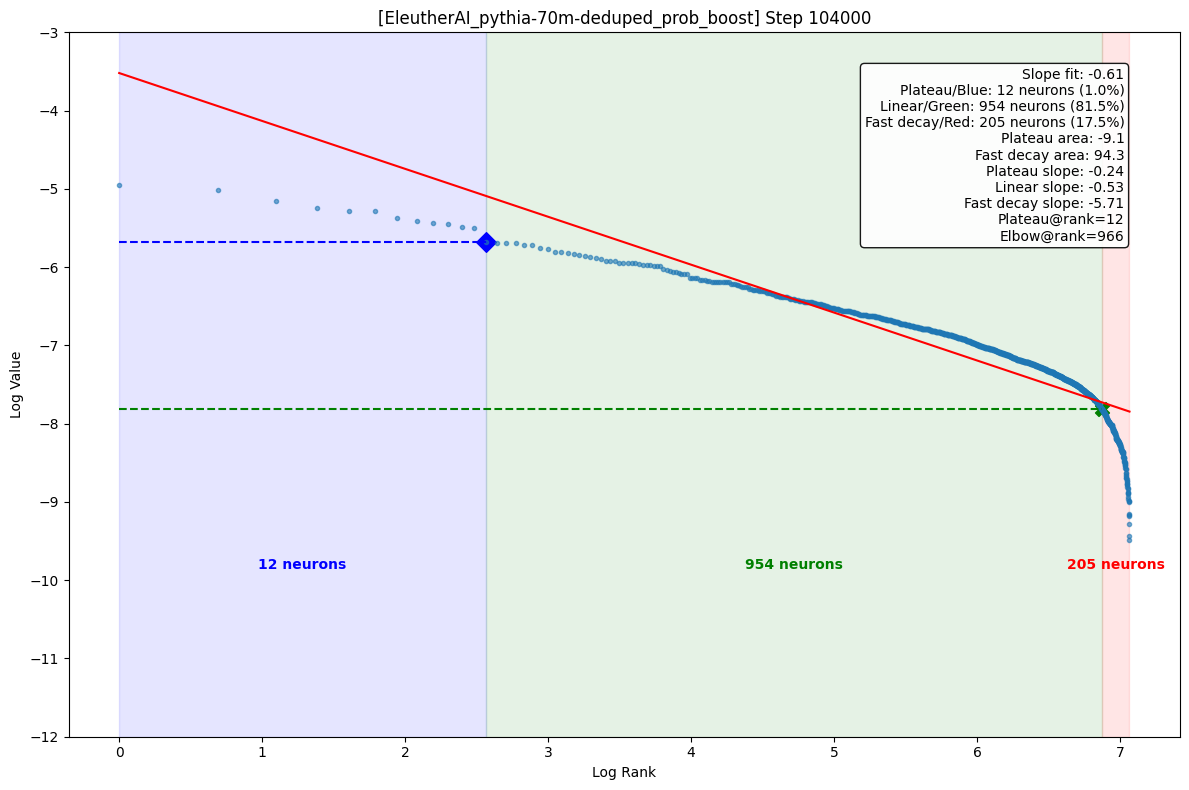

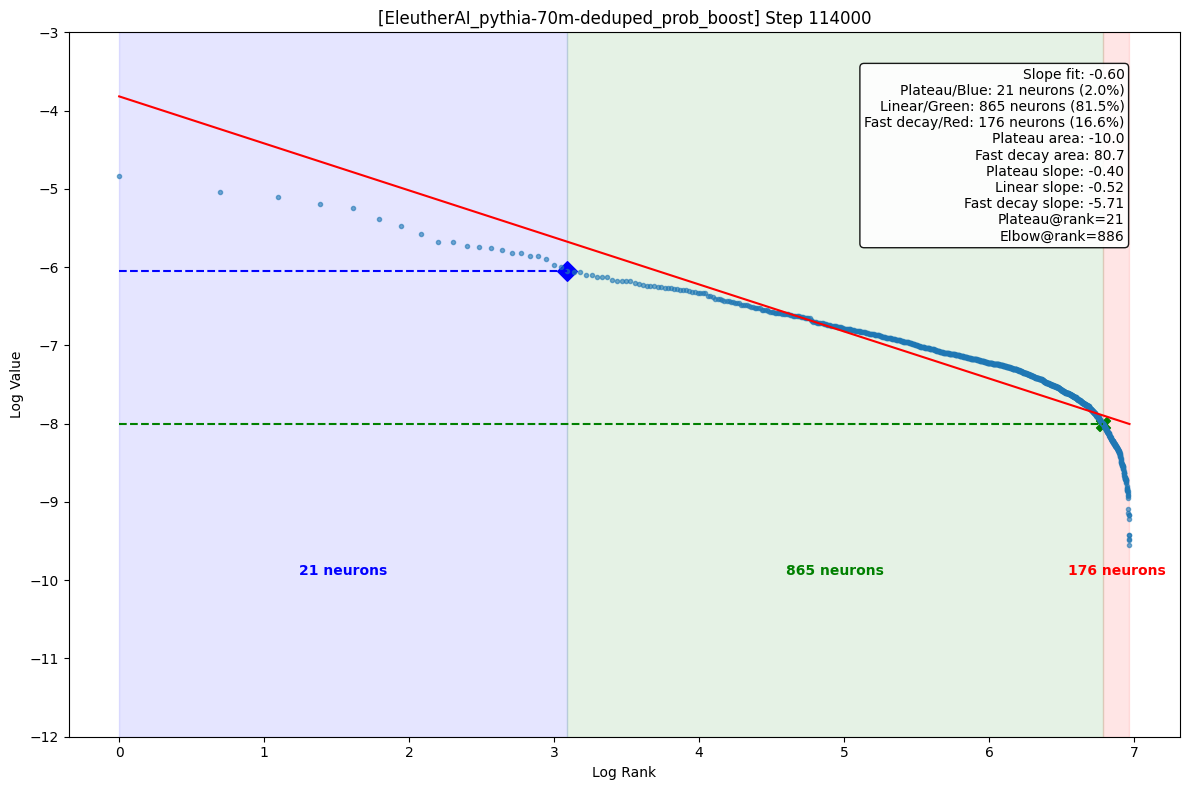

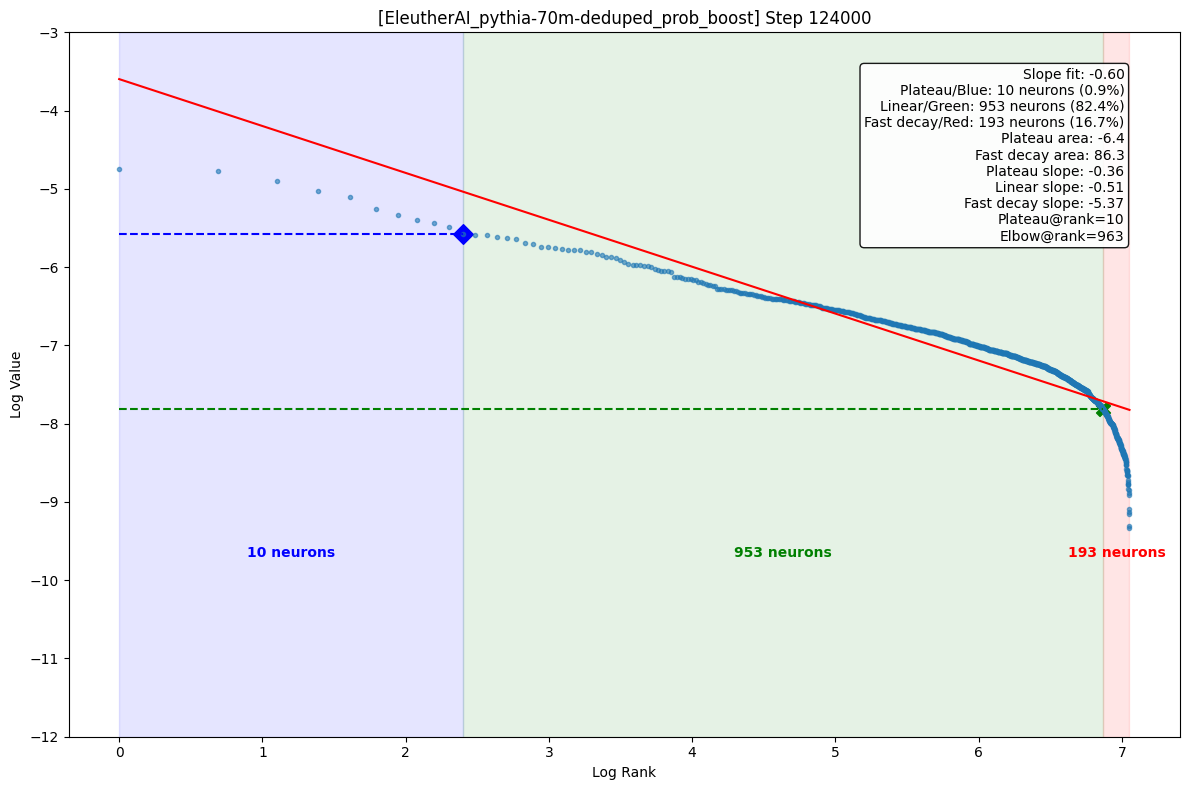

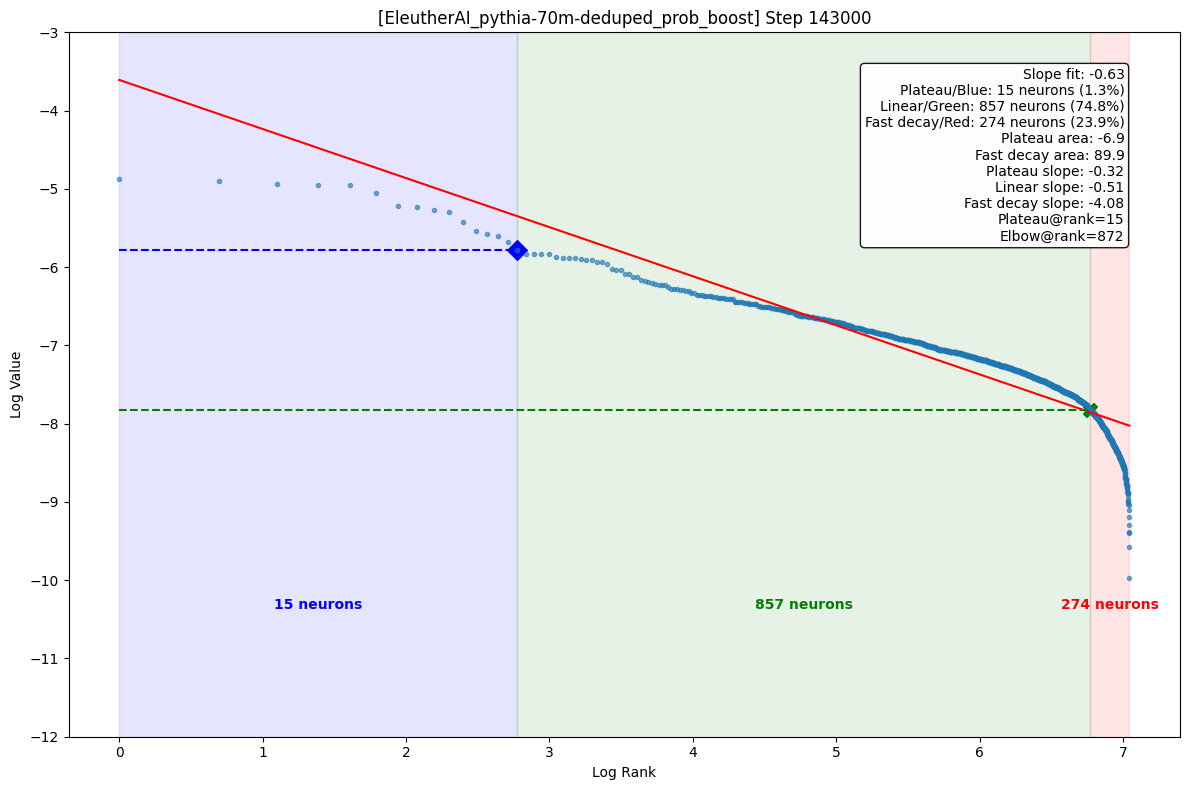

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_1297/3655914063.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  "sig": abs_second_derivatives[max_change_idx] / threshold


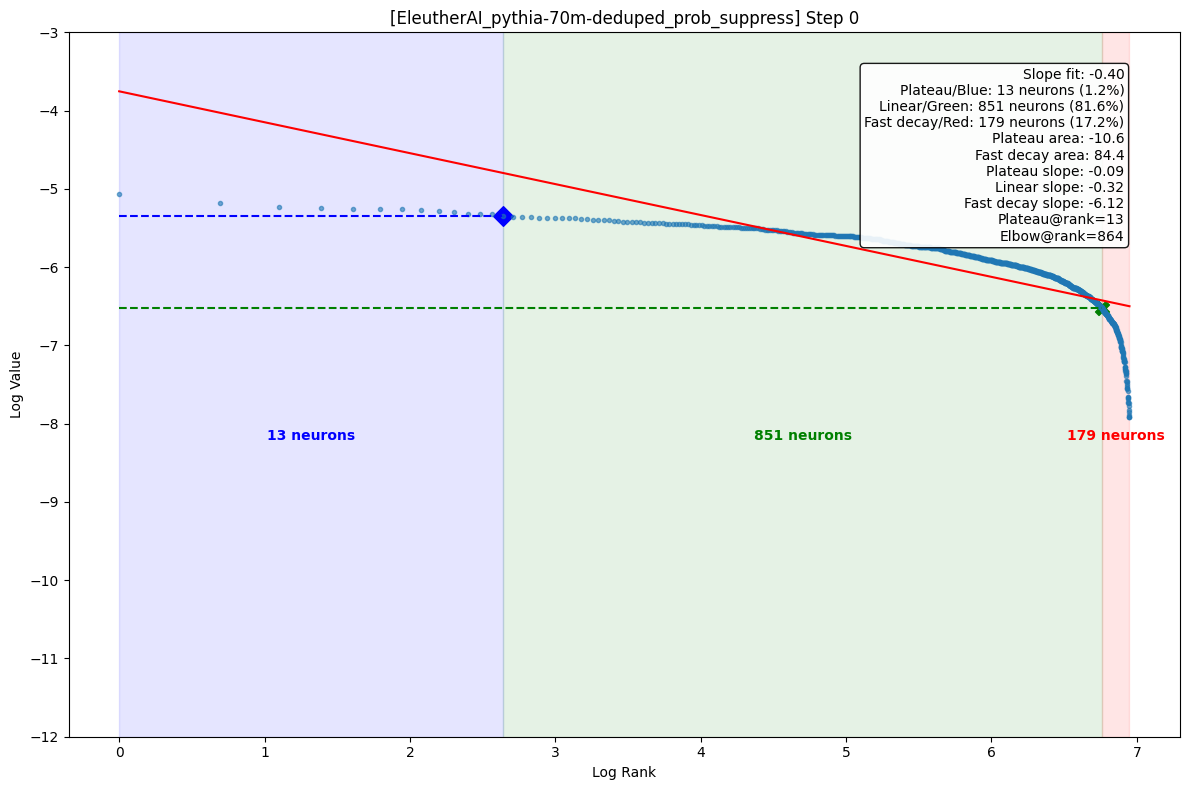

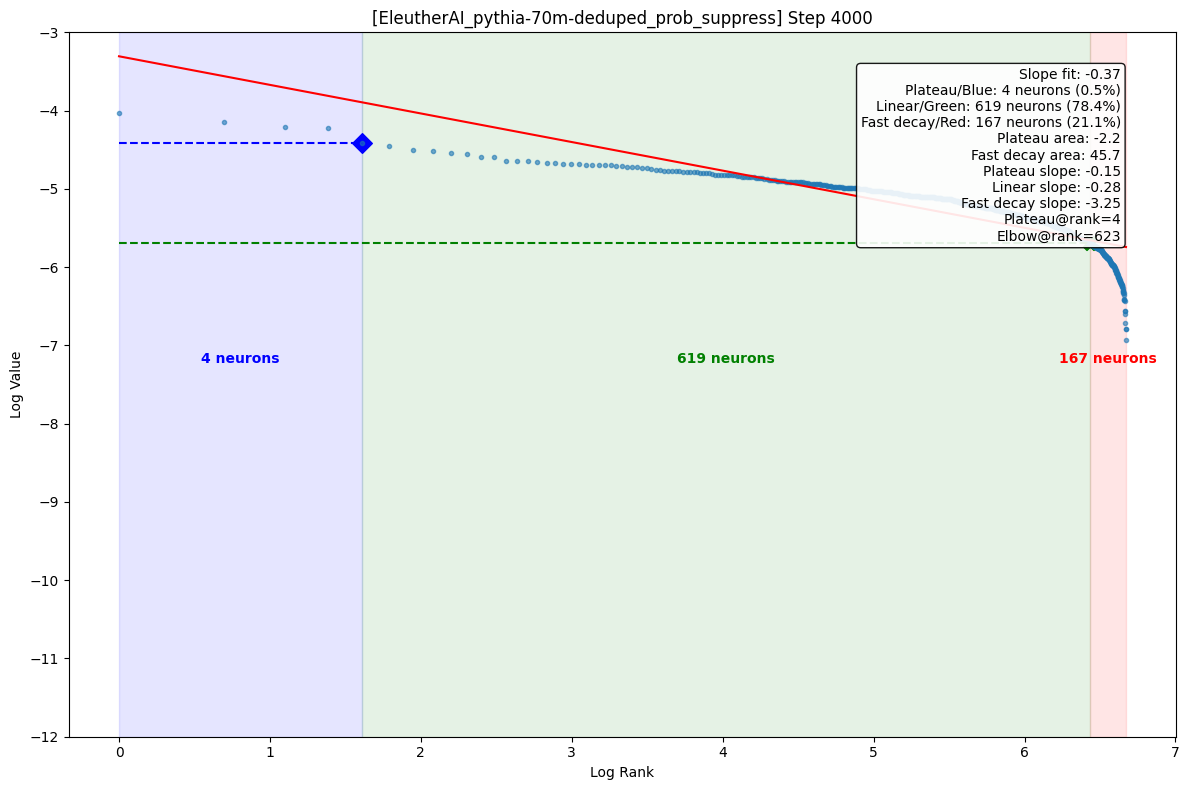

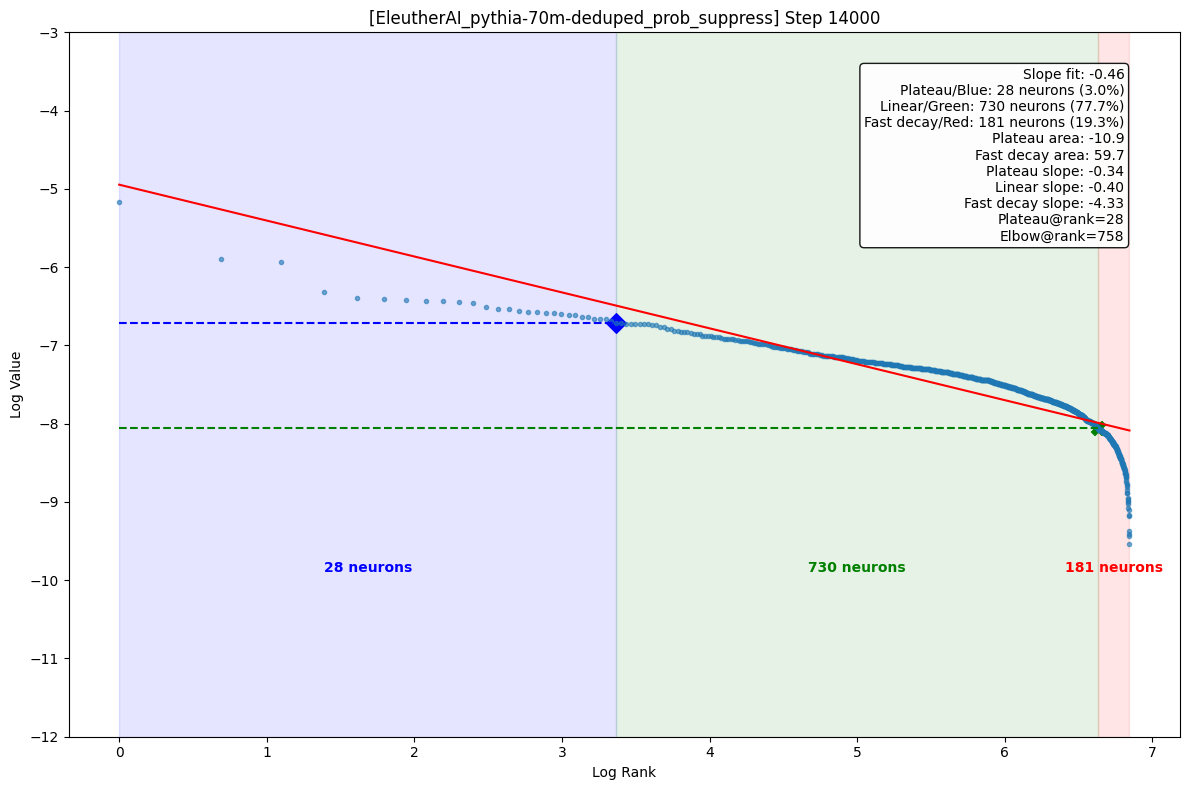

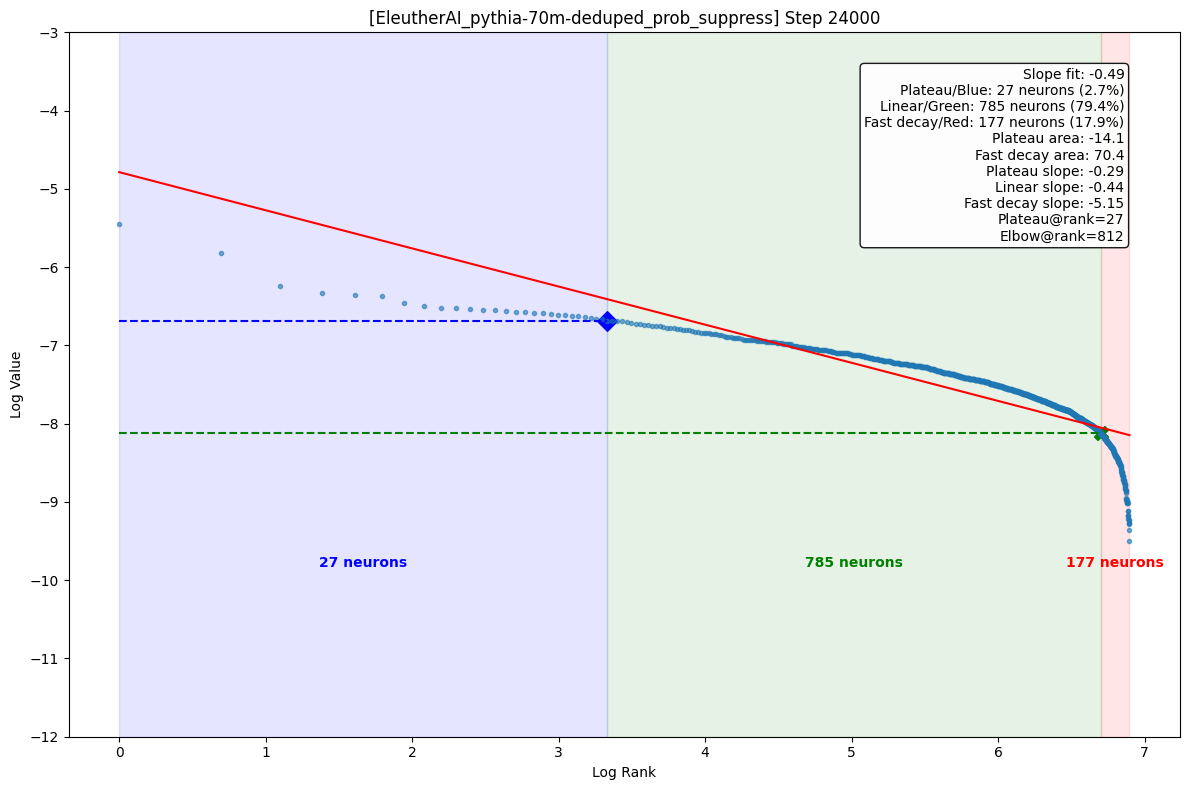

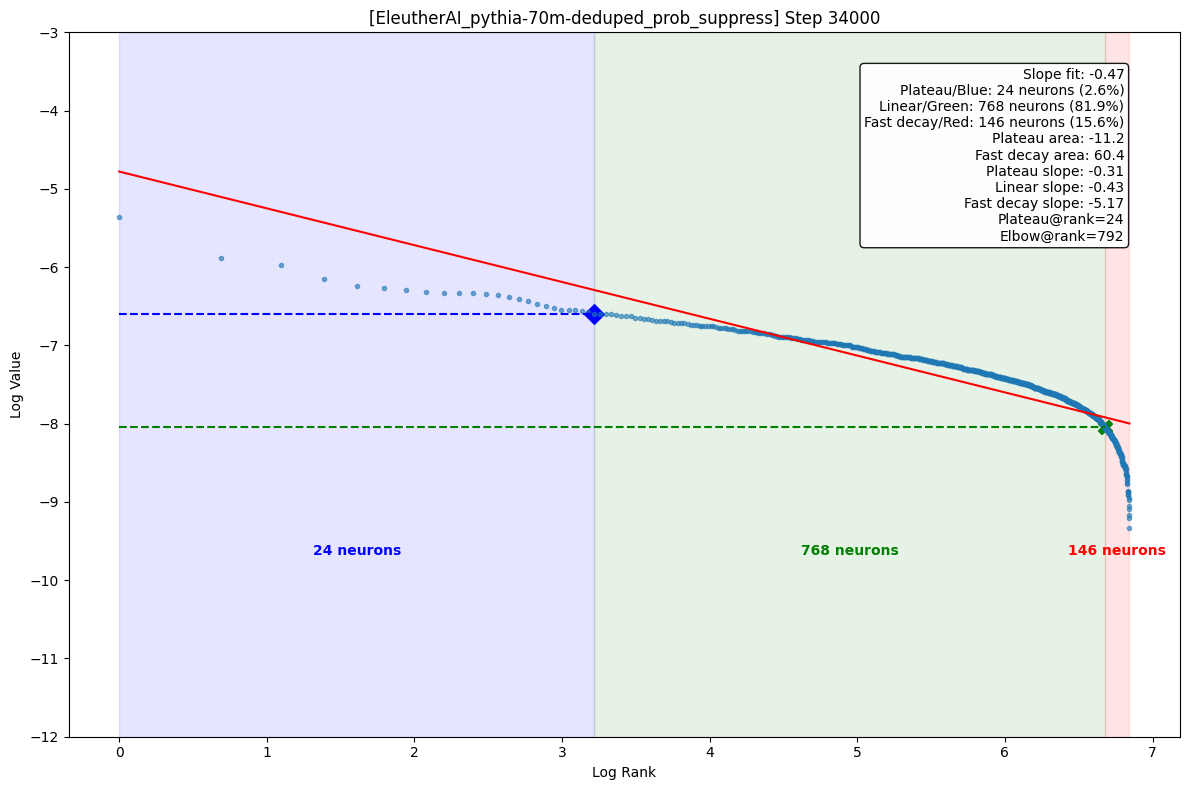

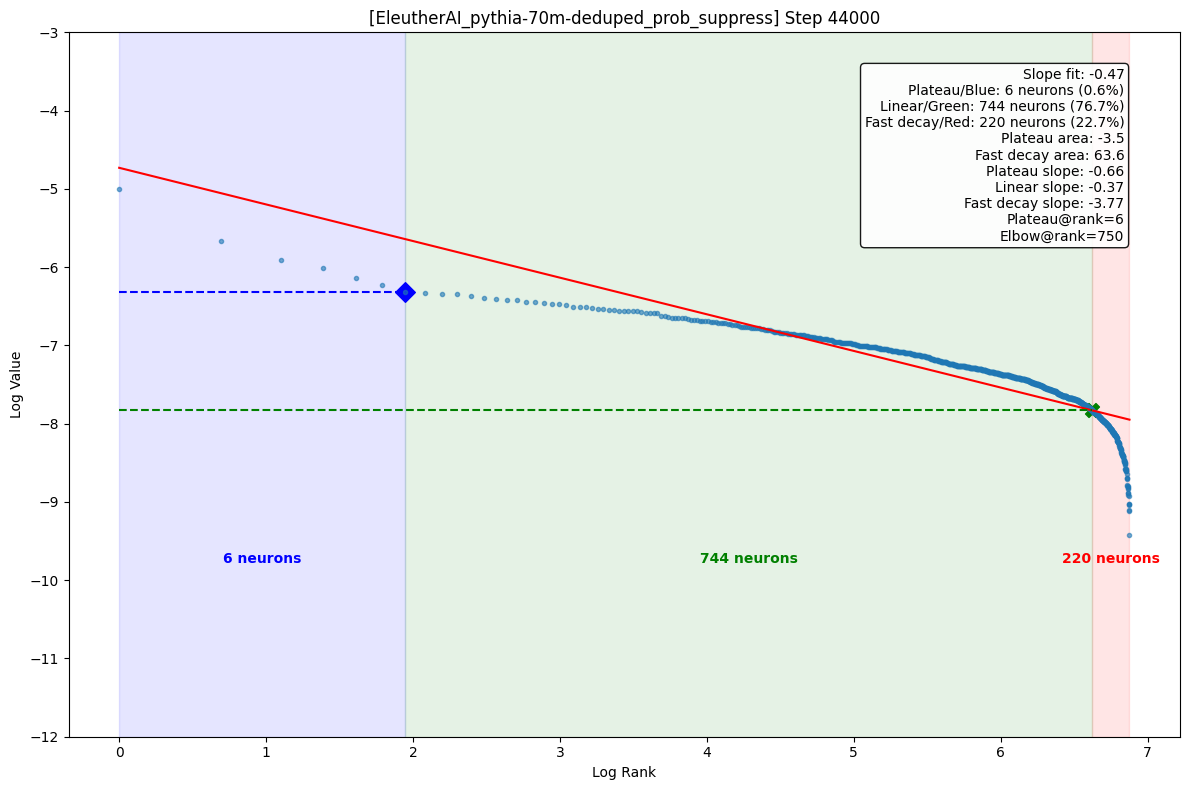

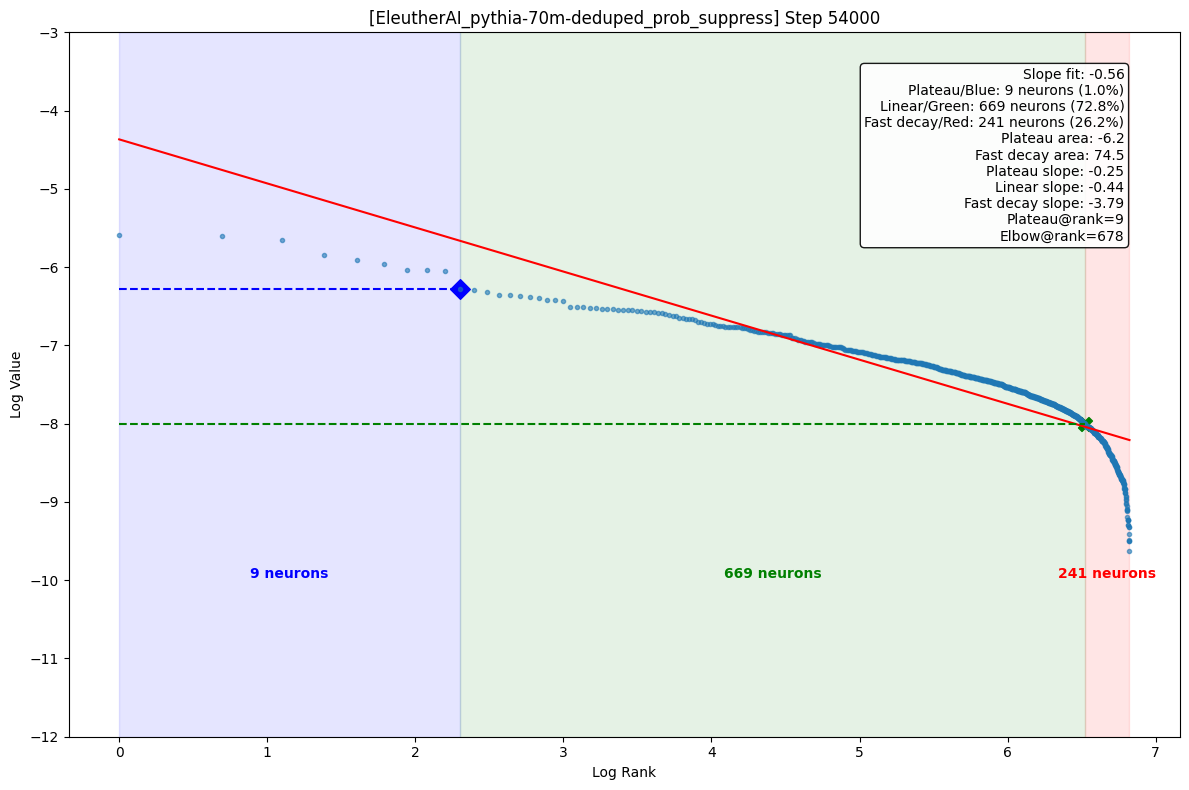

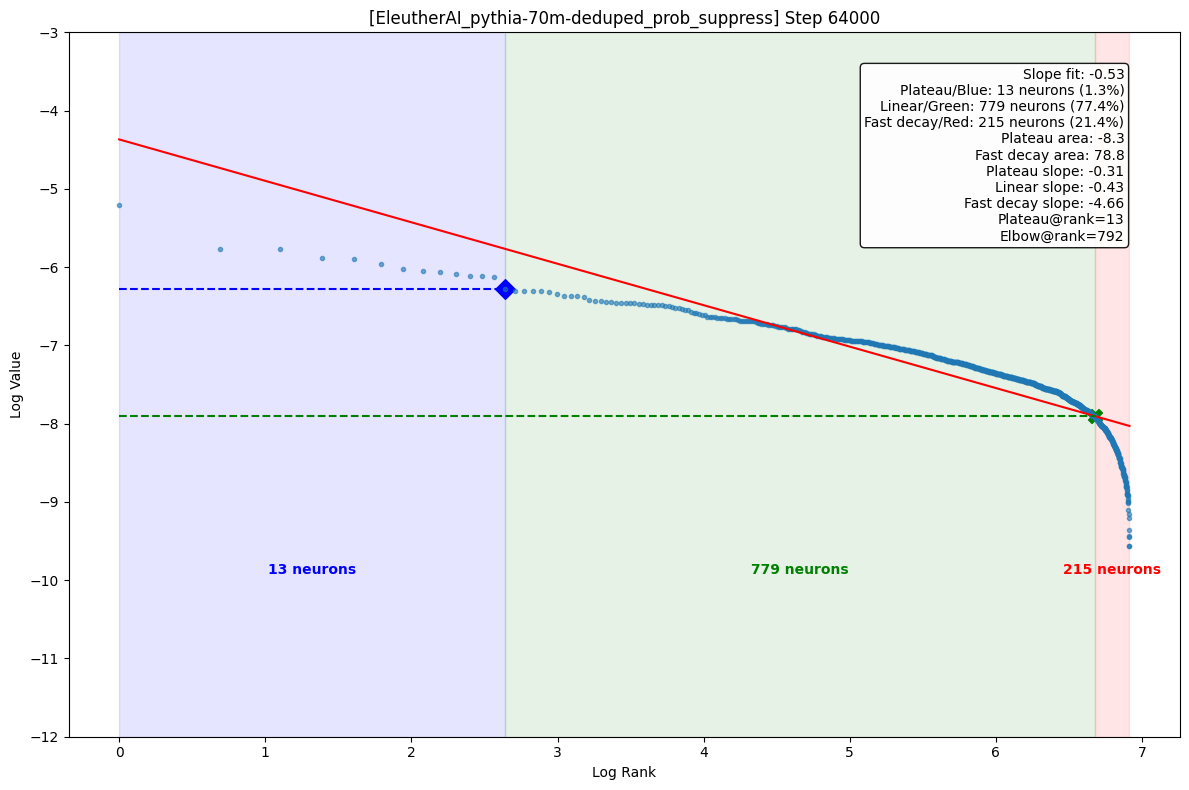

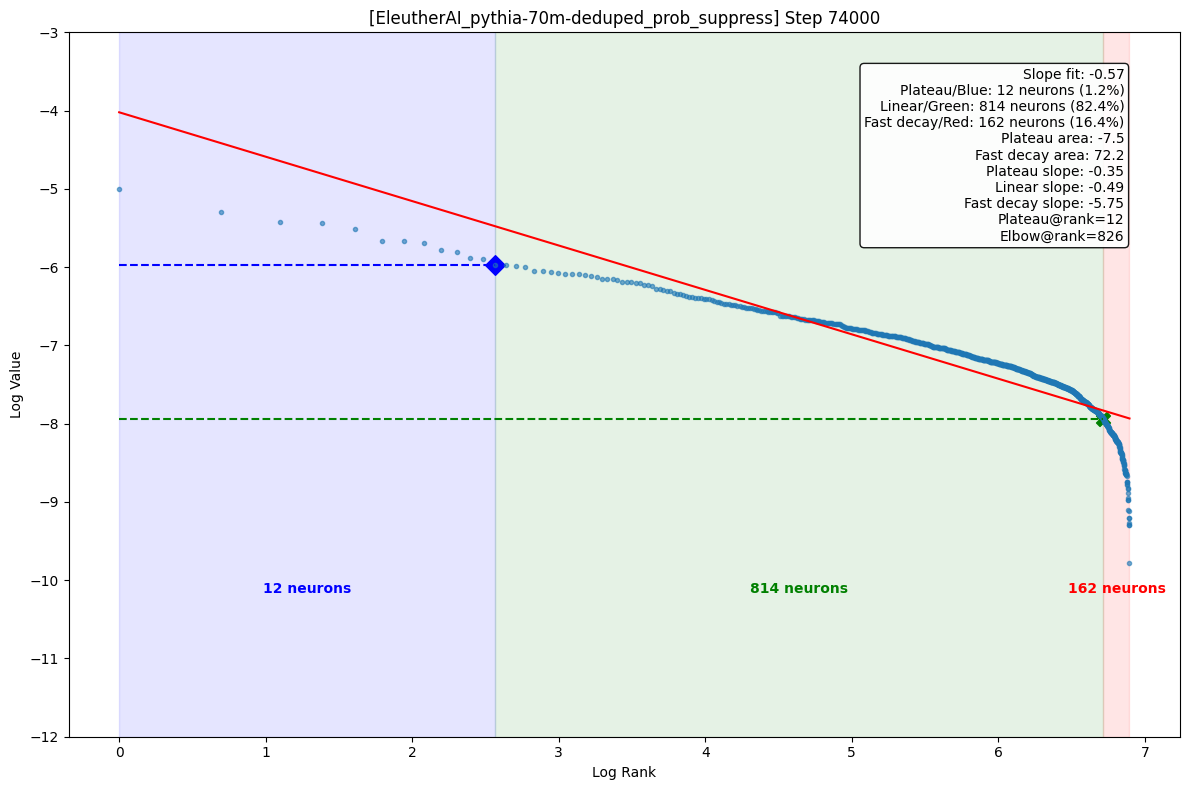

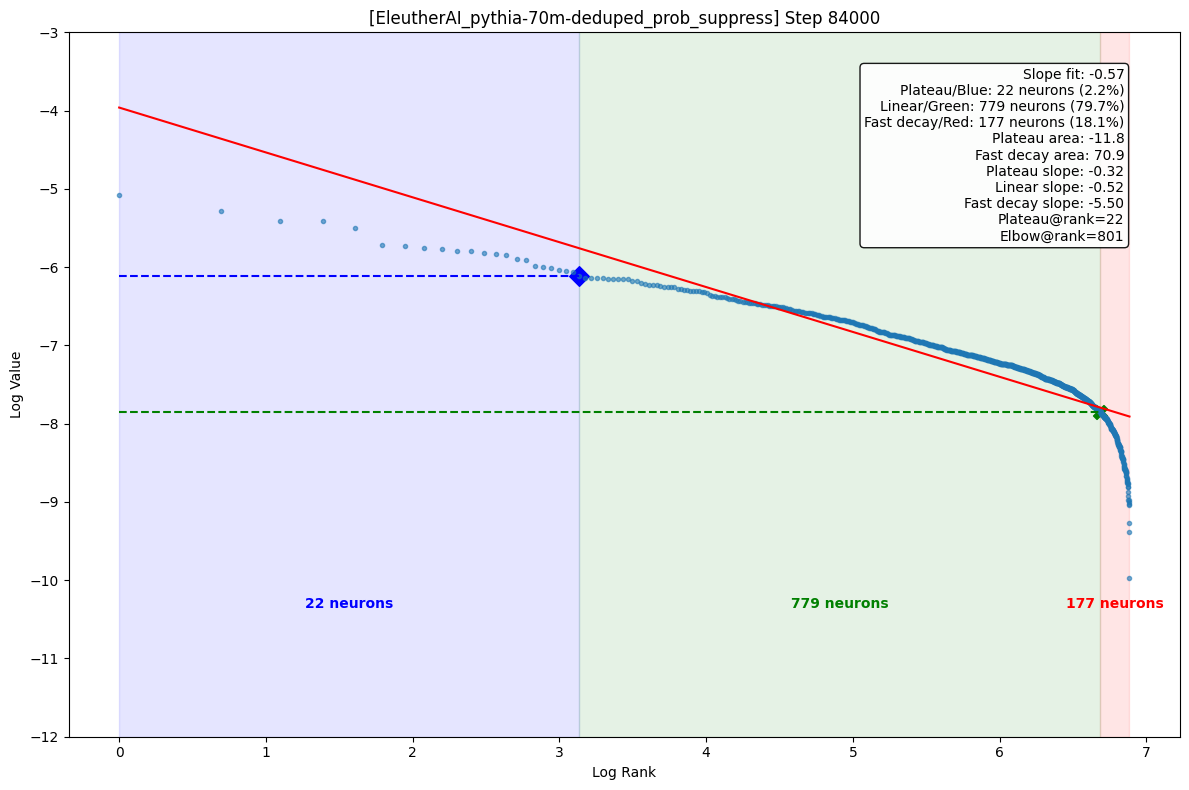

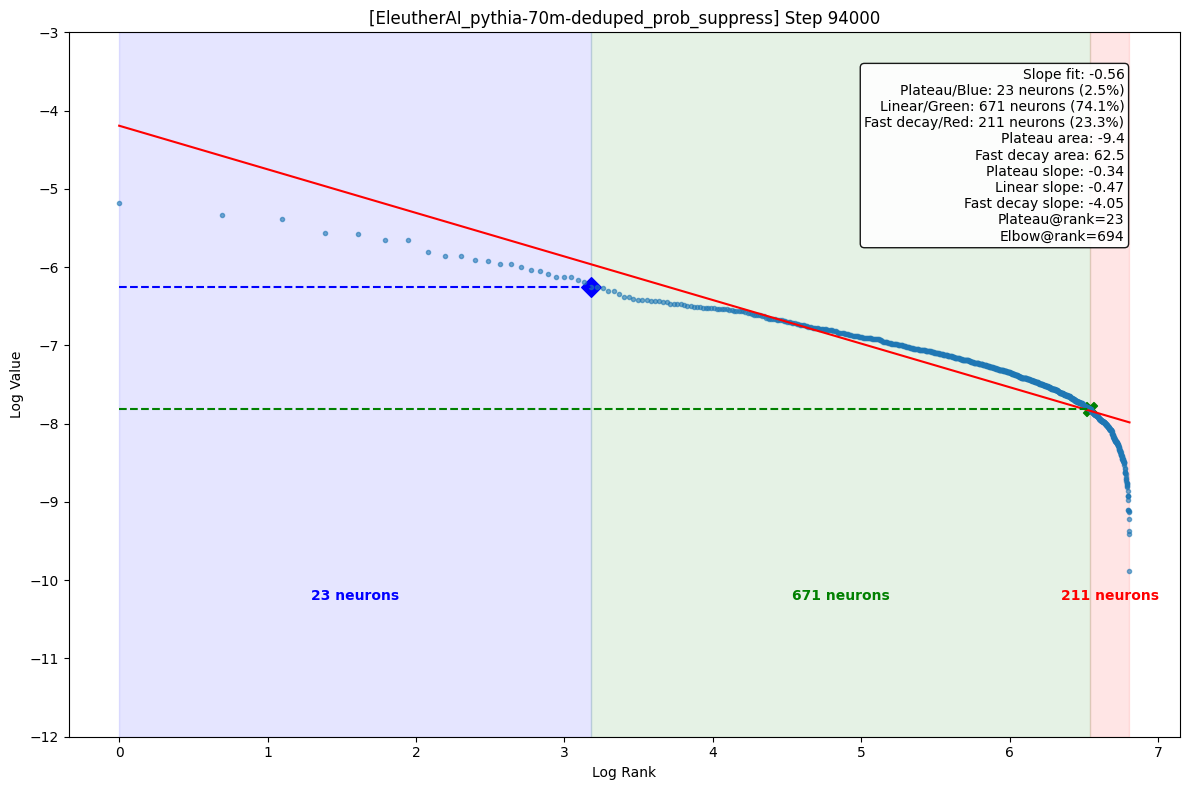

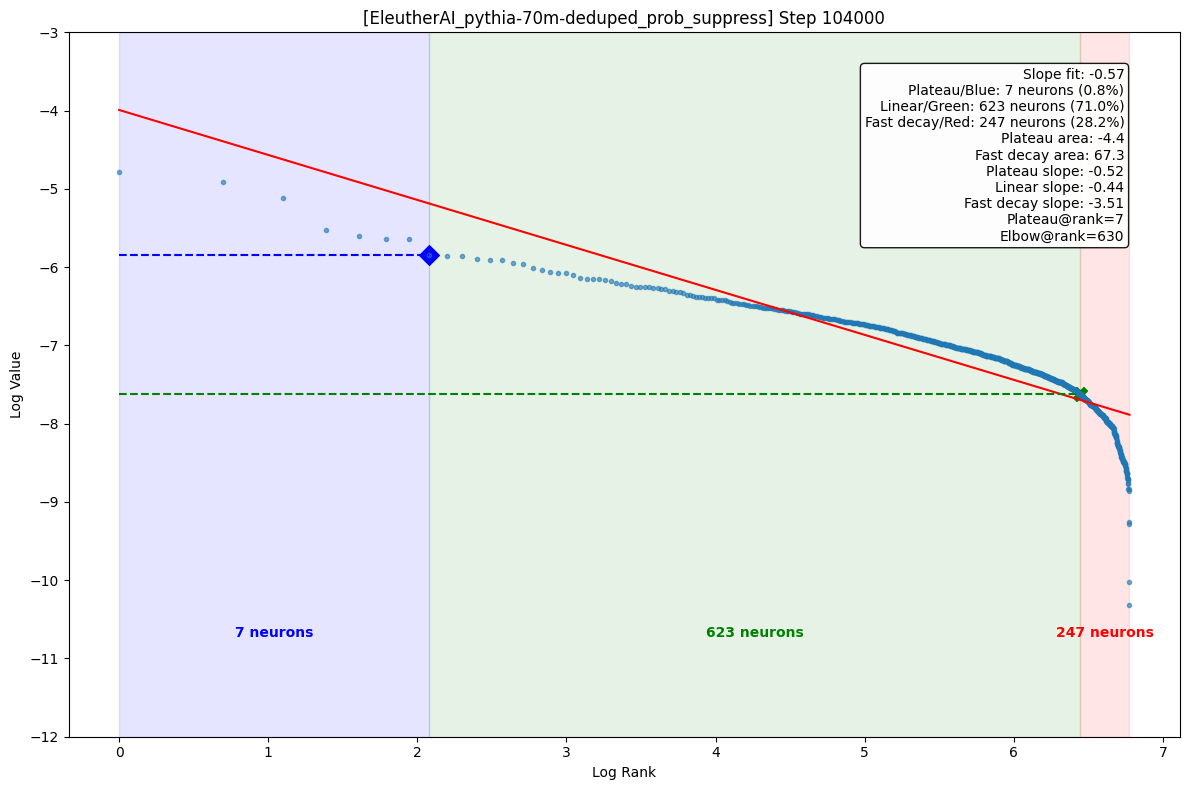

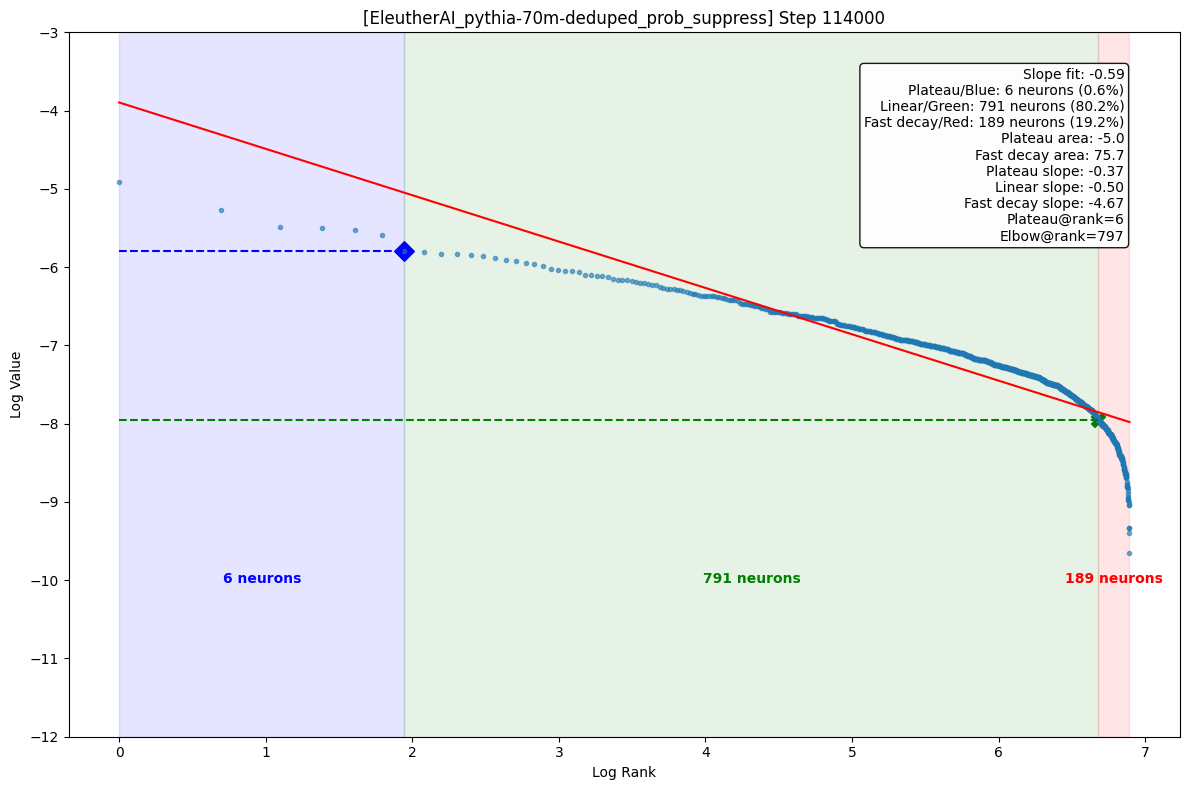

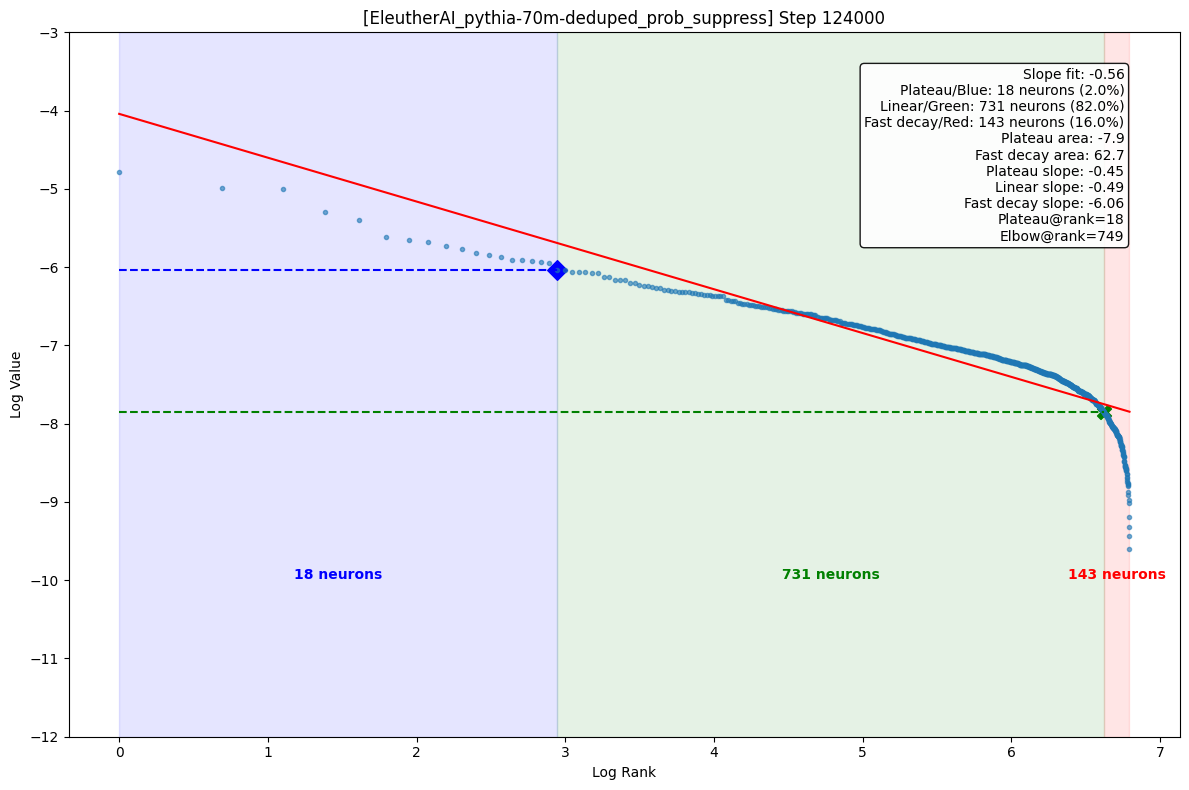

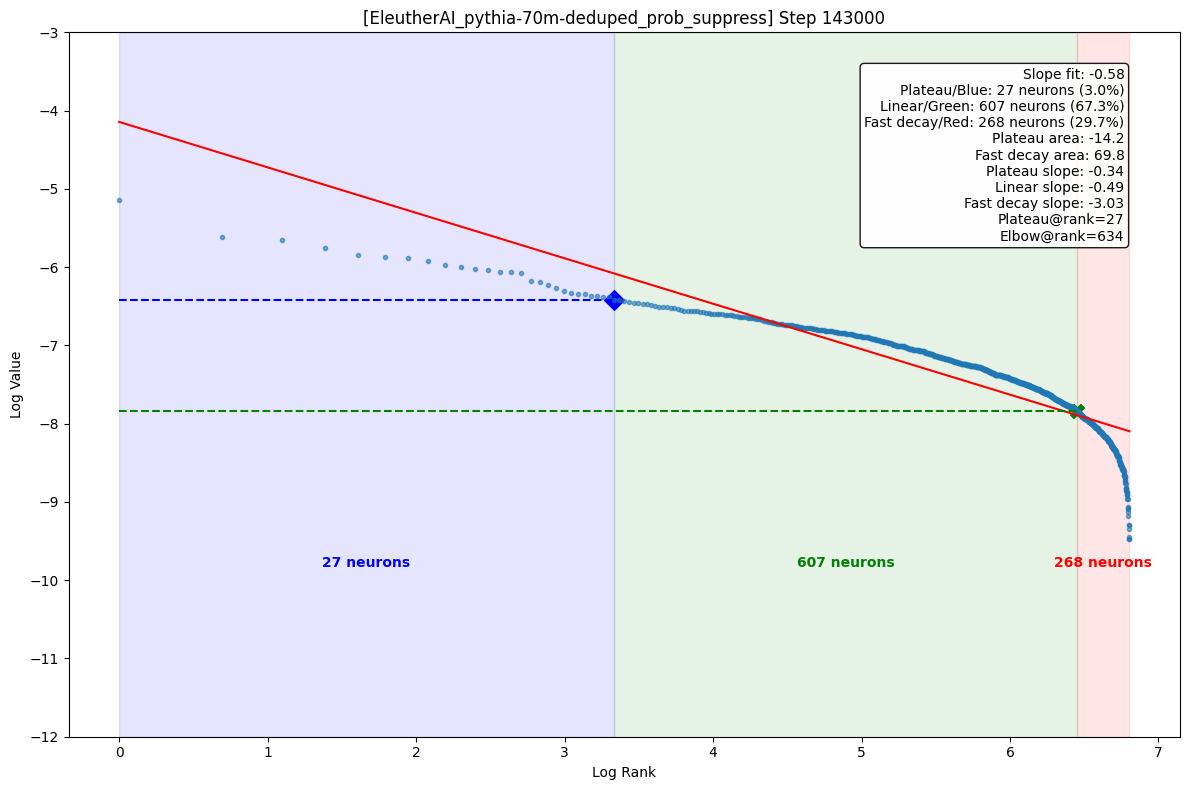

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_1297/3655914063.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  "sig": abs_second_derivatives[max_change_idx] / threshold


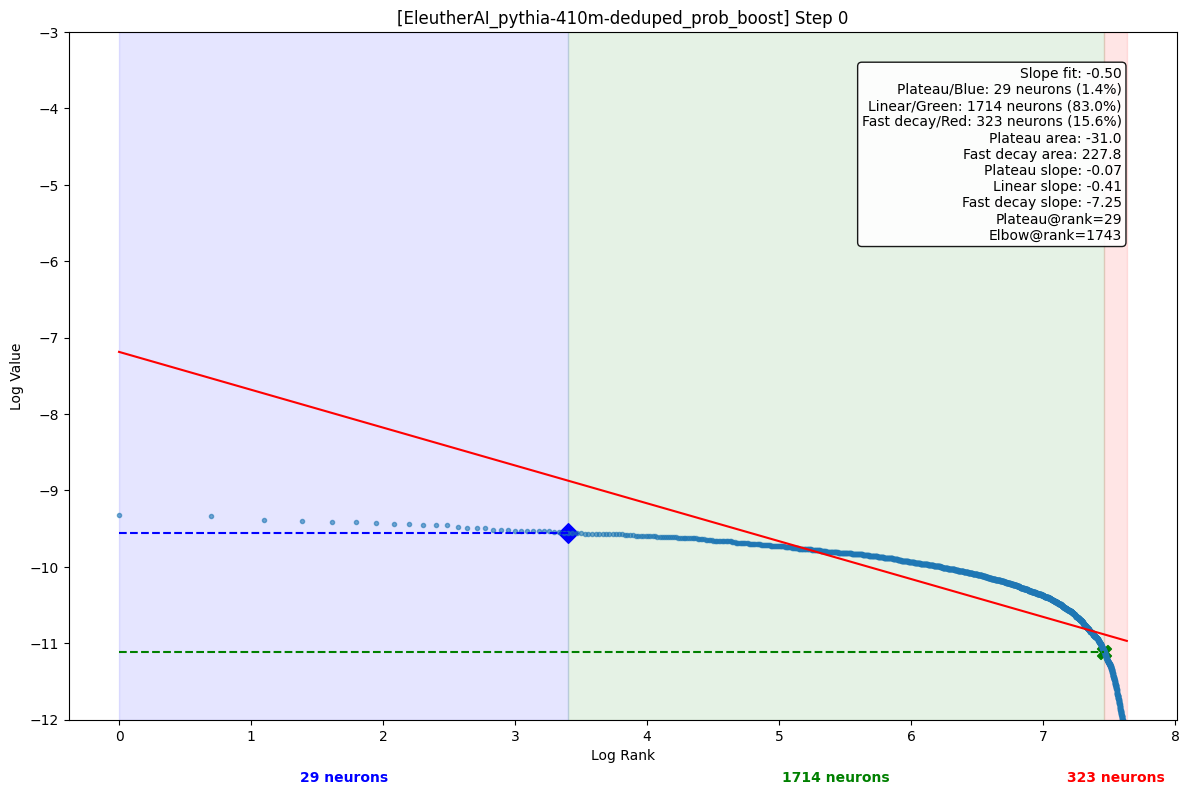

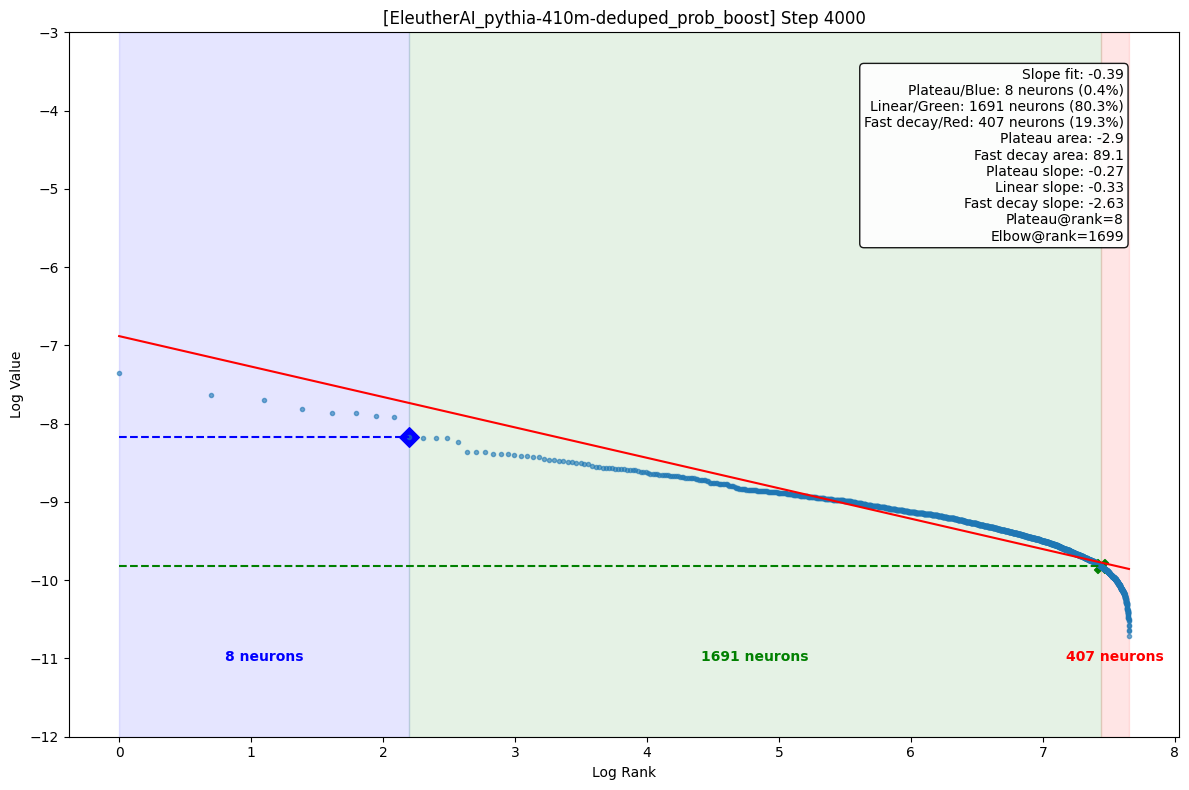

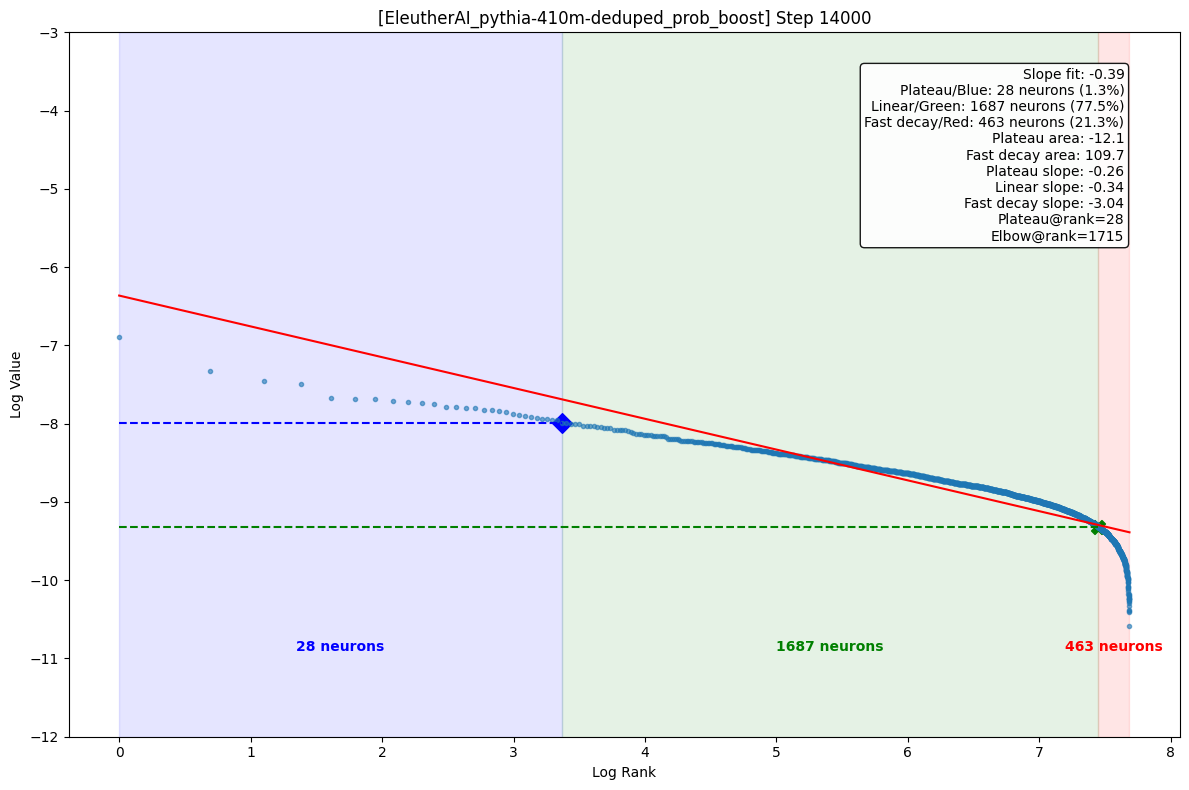

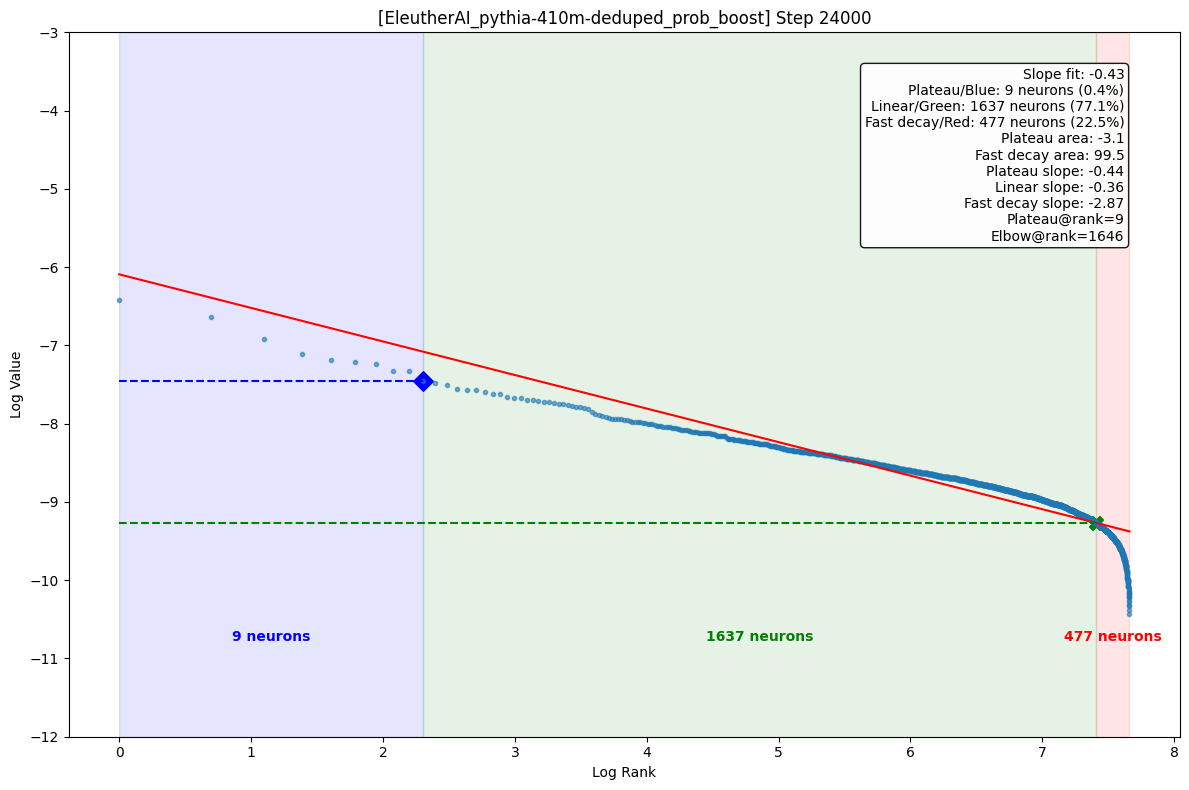

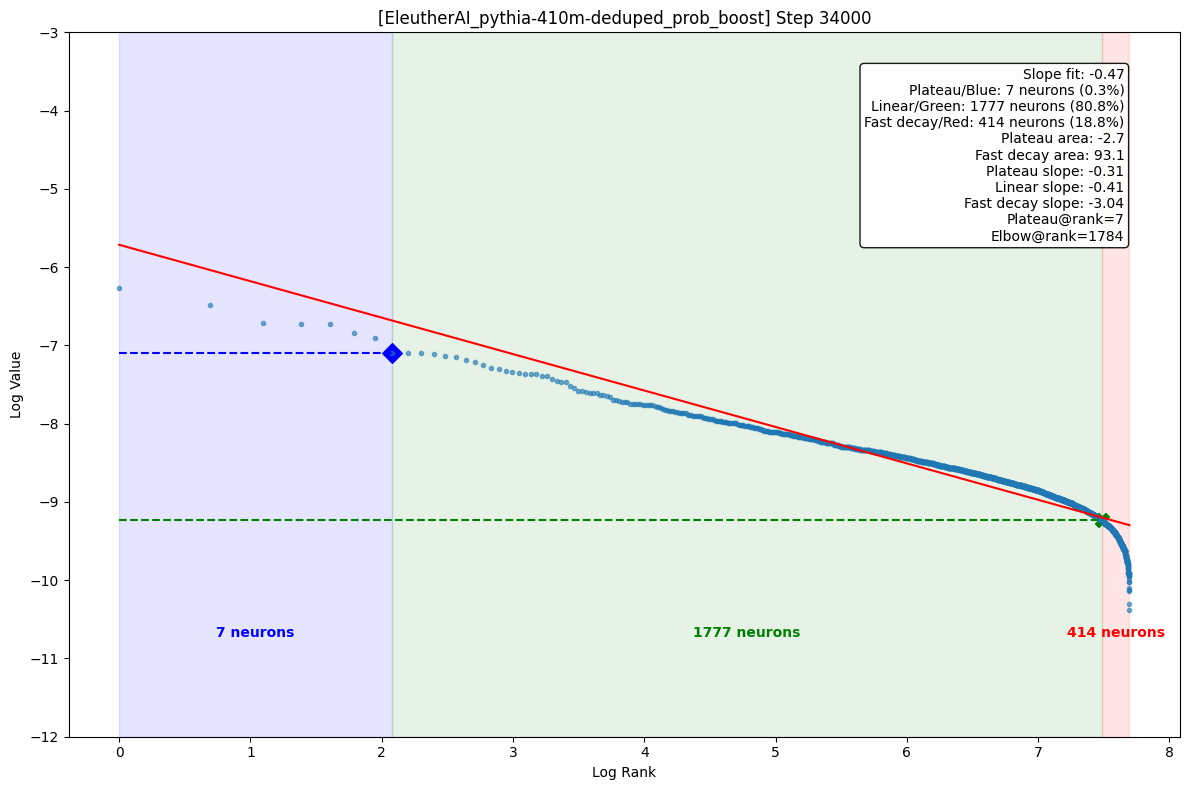

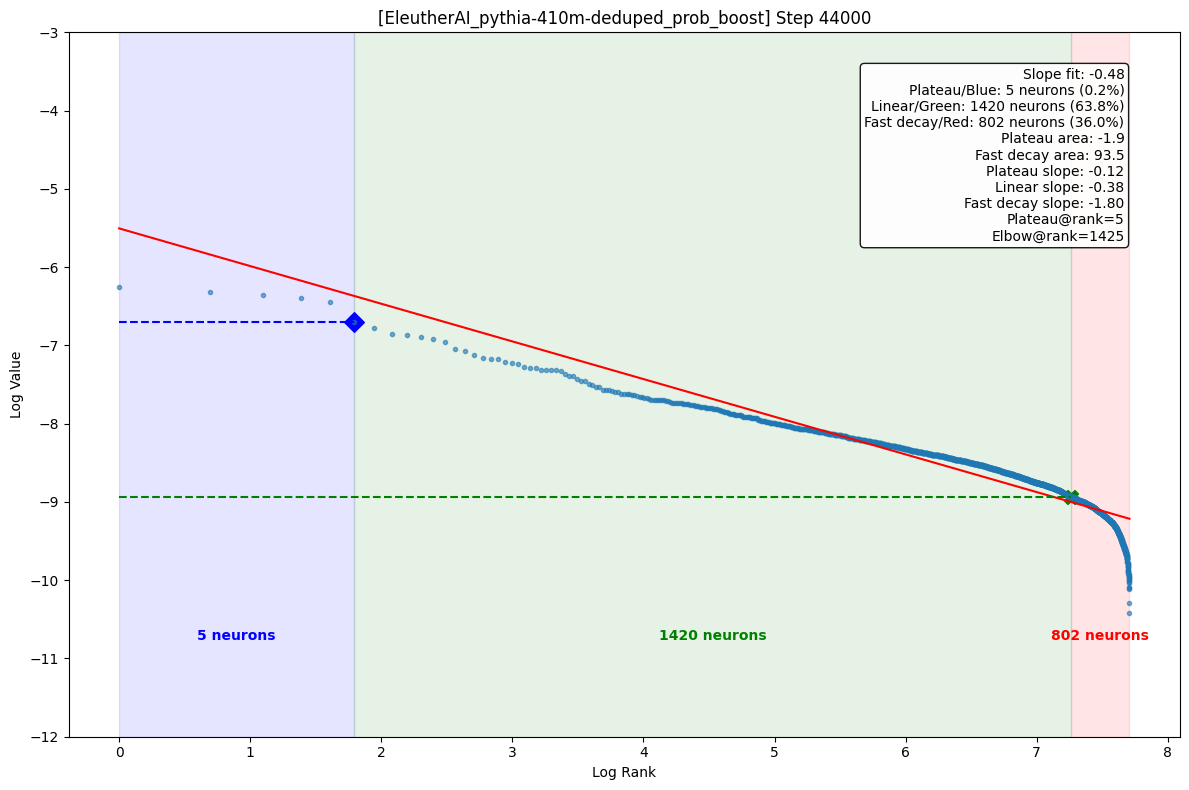

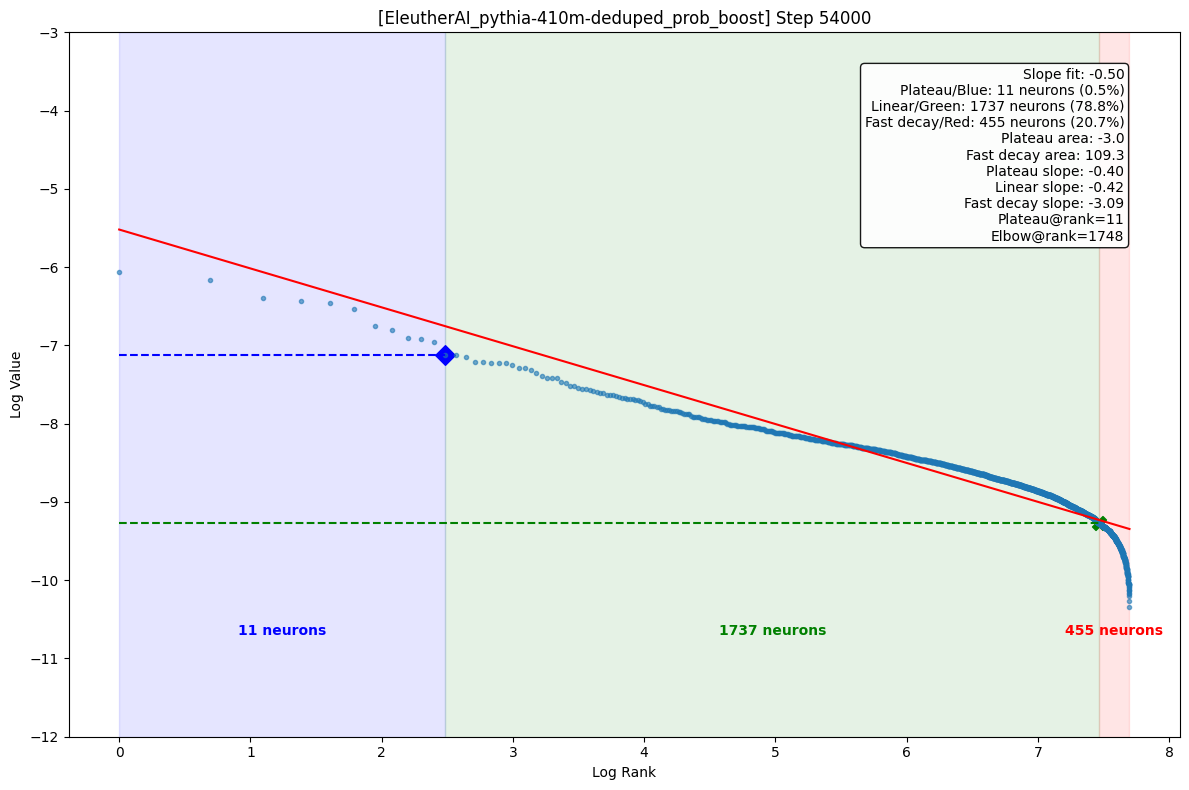

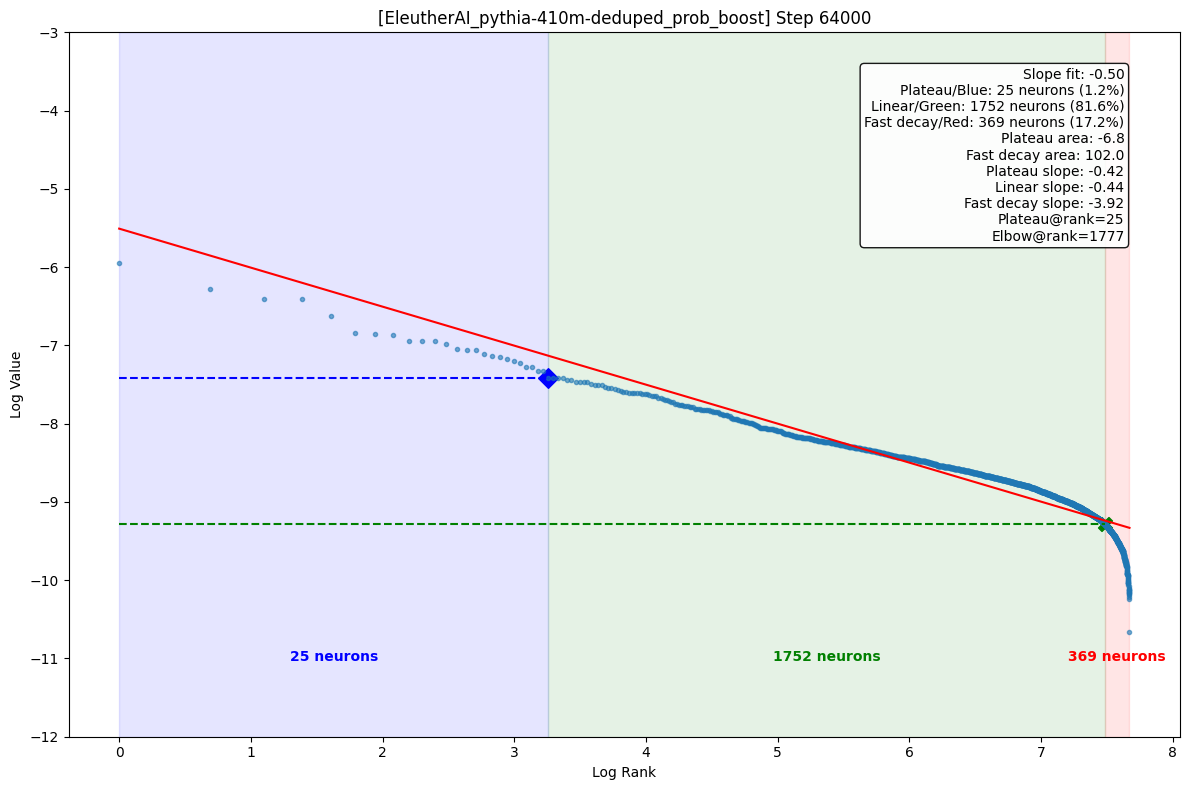

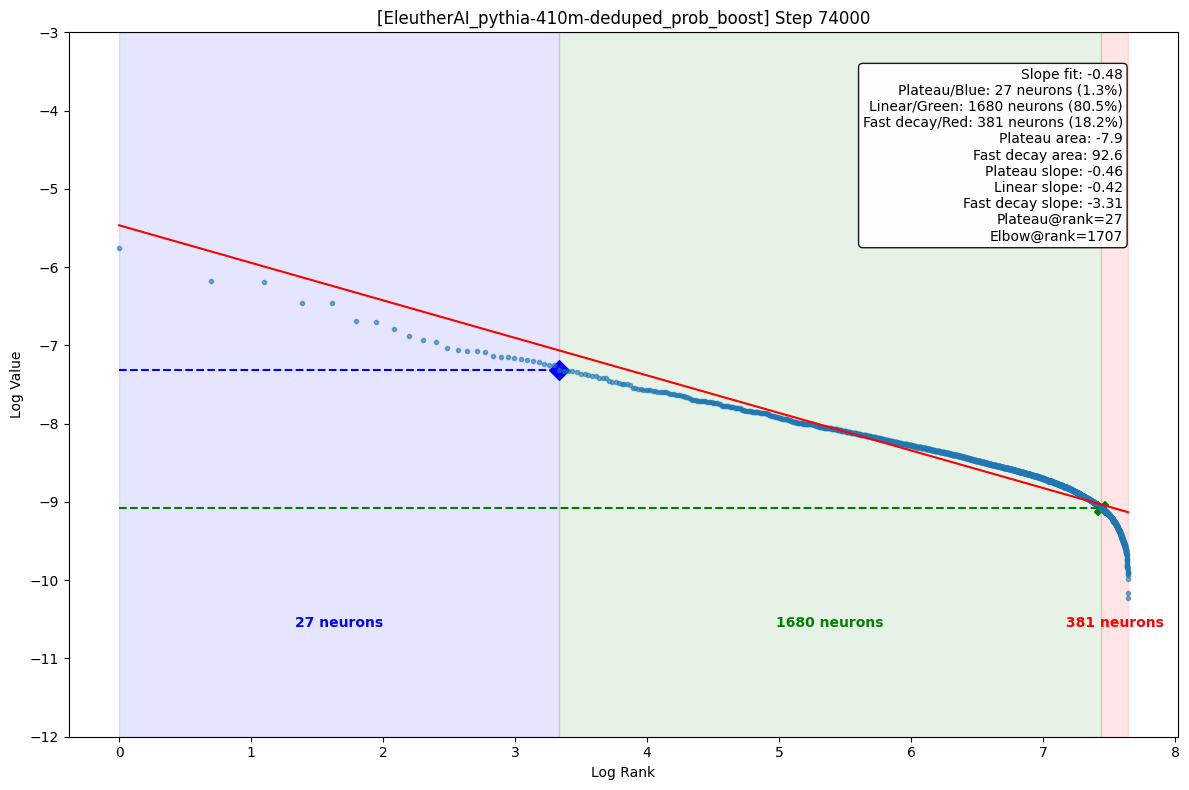

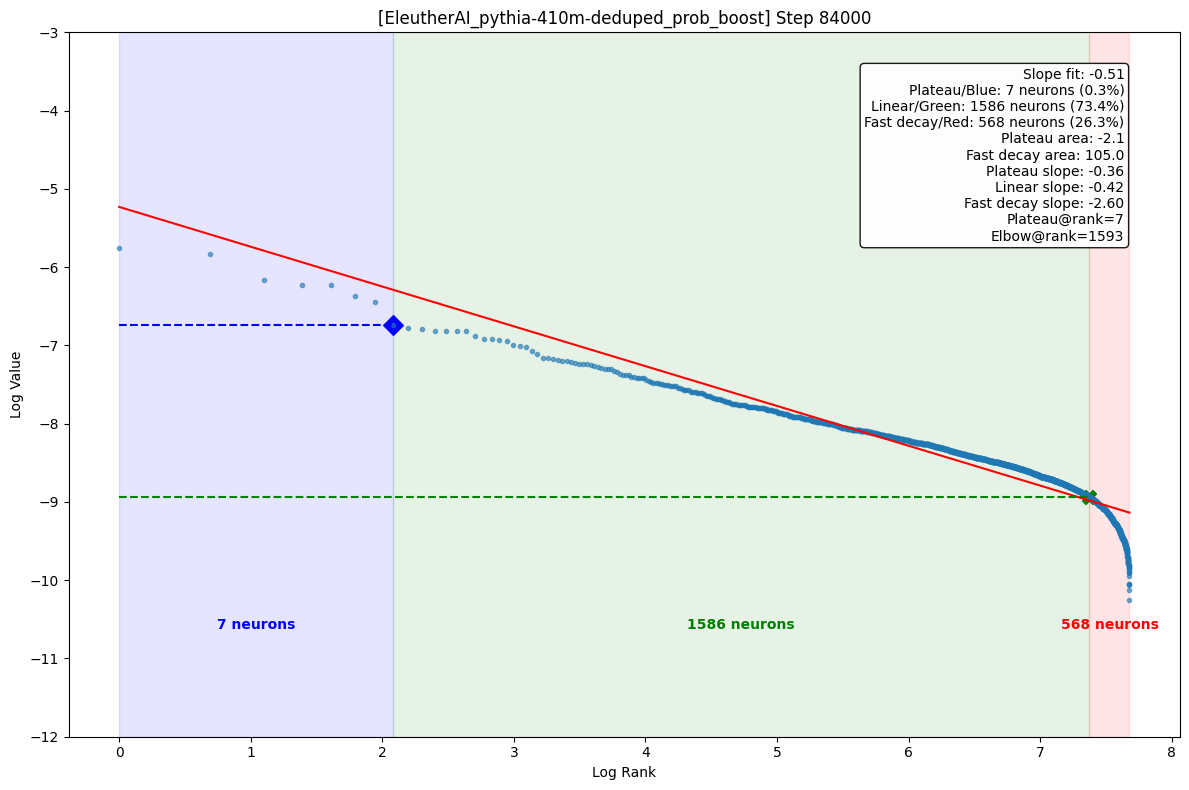

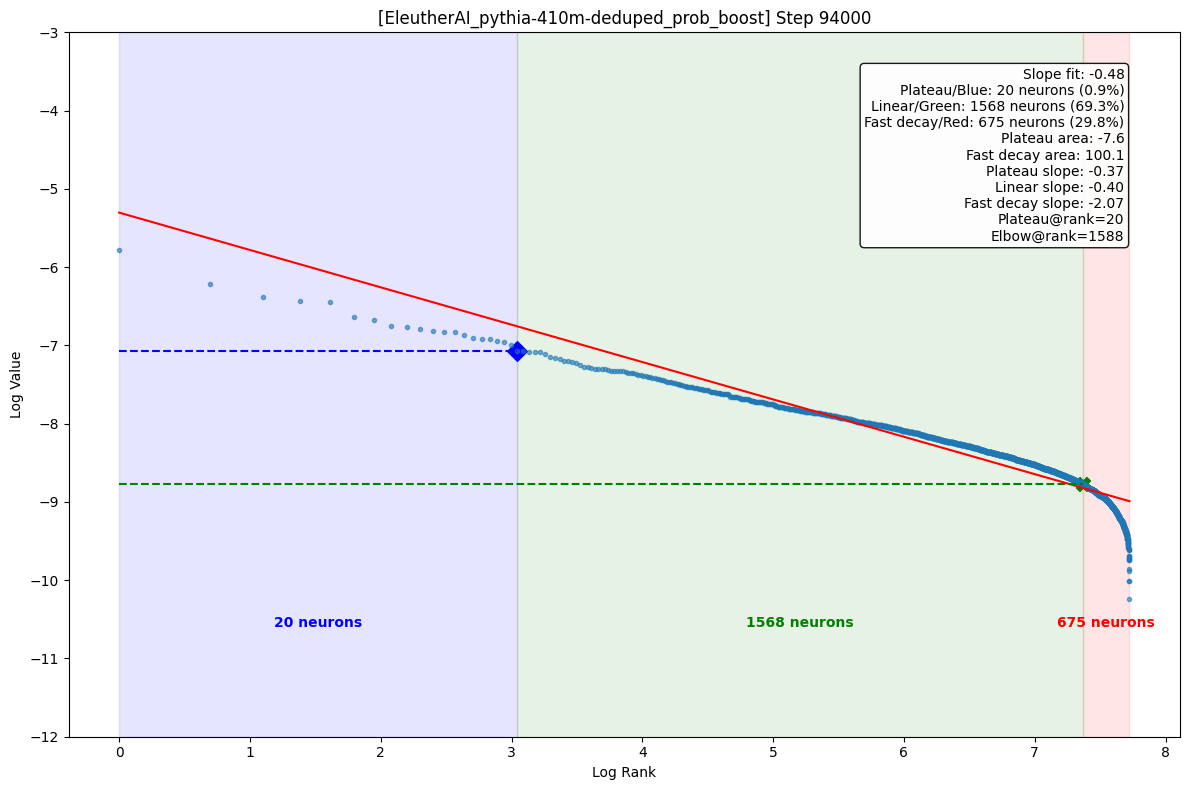

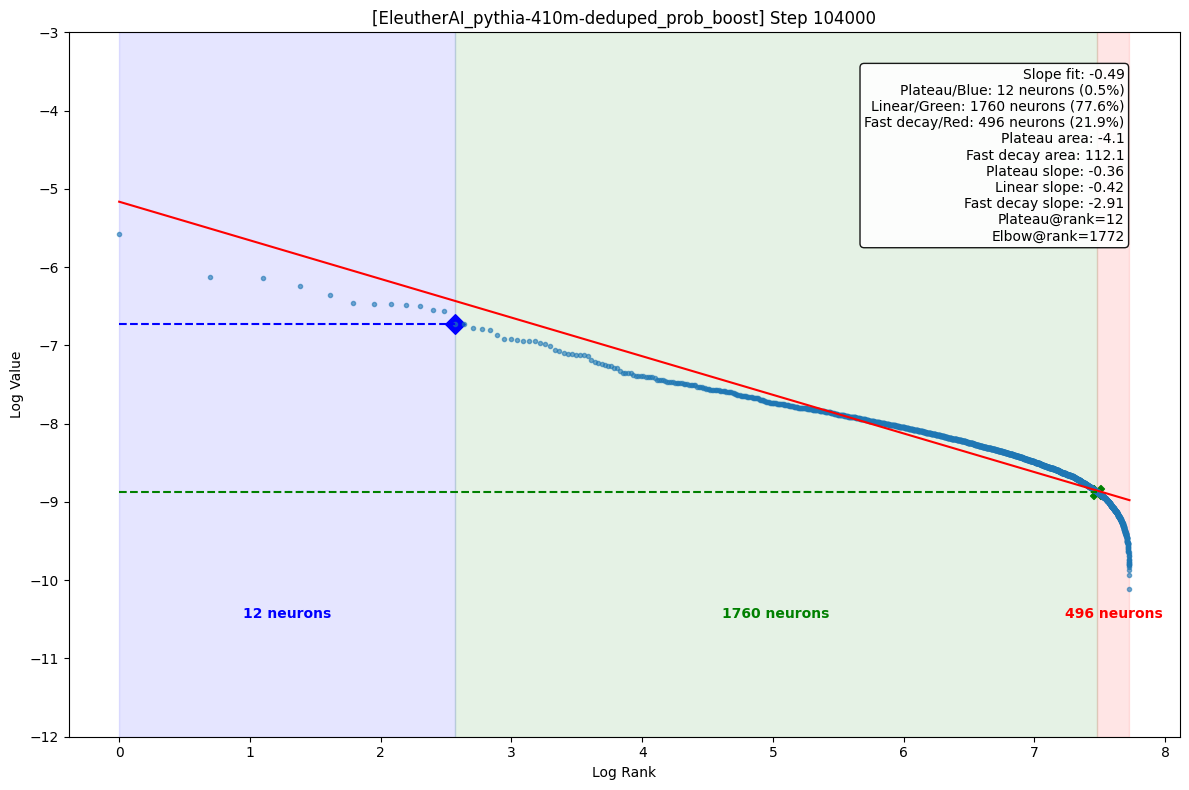

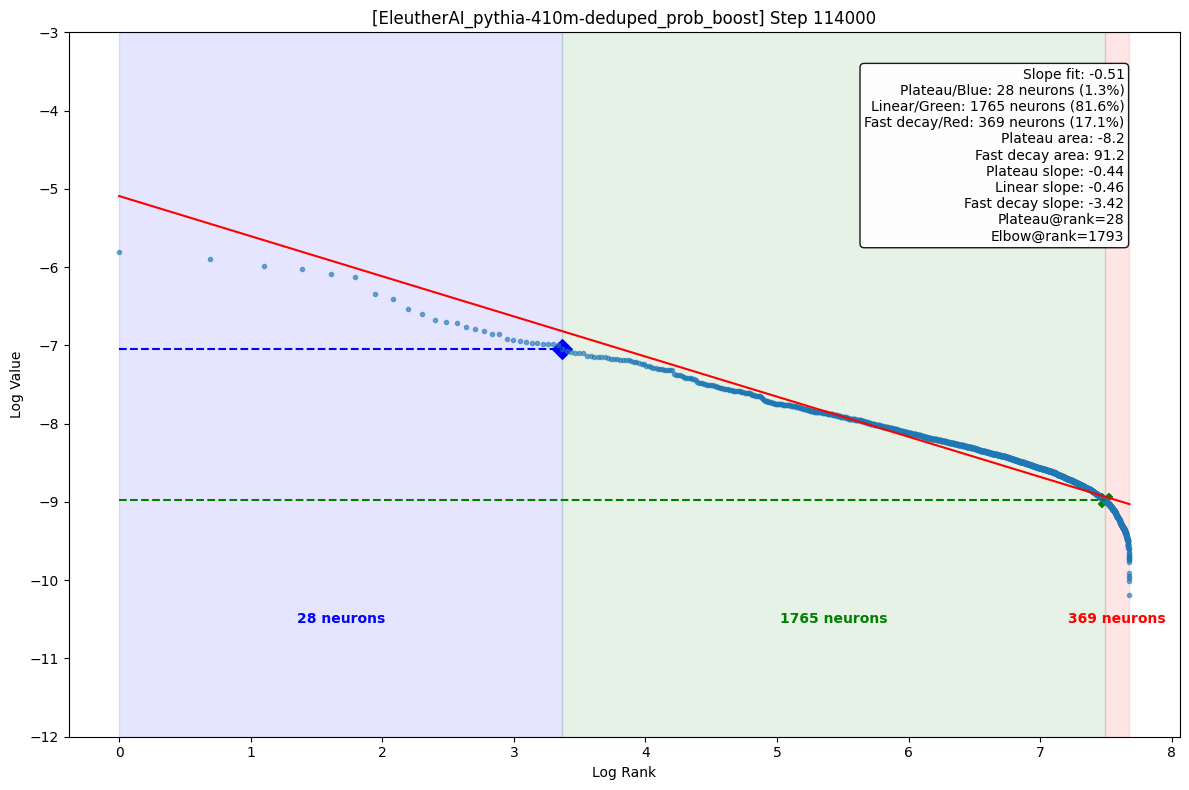

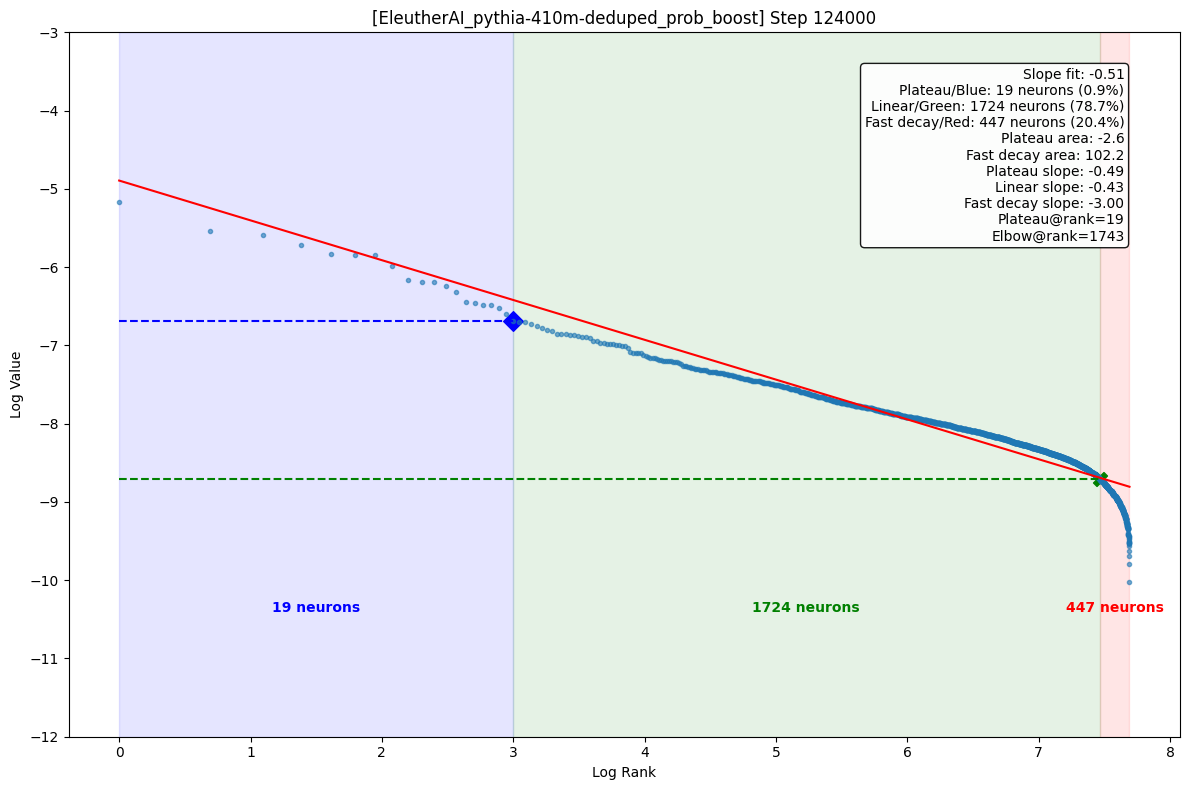

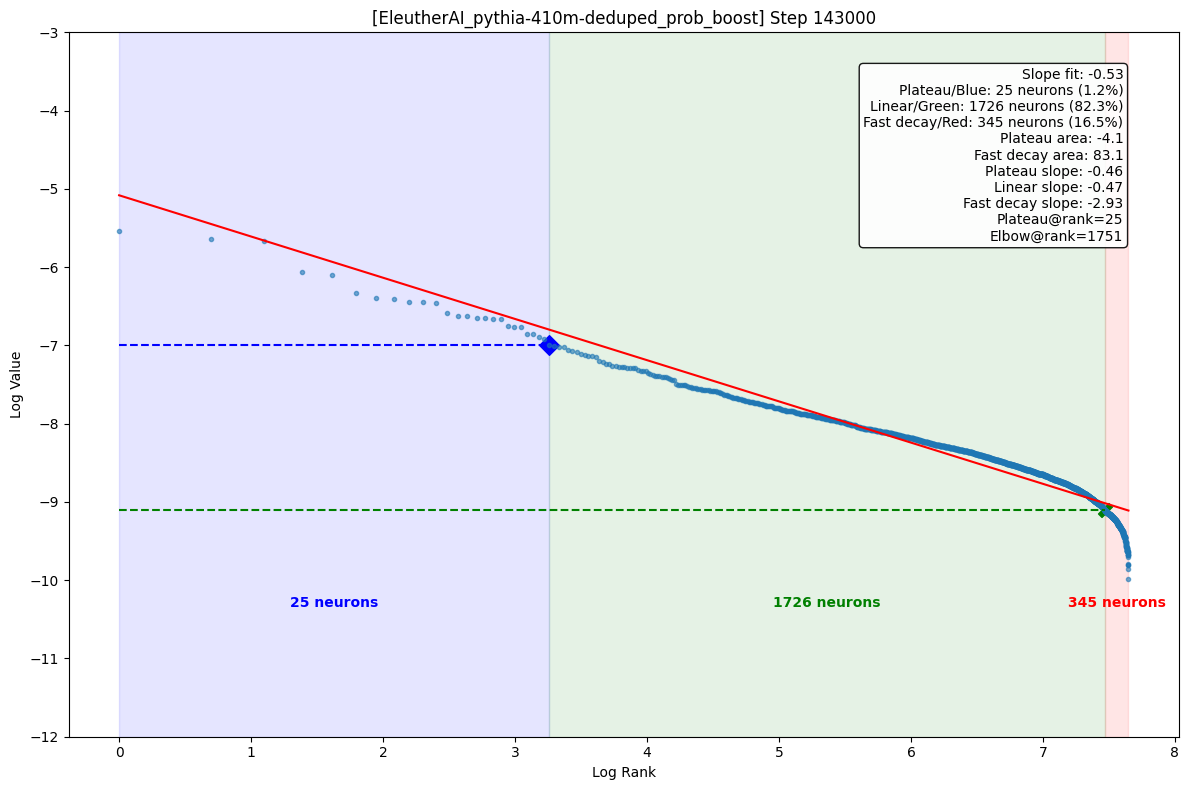

/var/folders/c2/336gdlh133qfynjgt7nm9jhw0000gn/T/ipykernel_1297/3655914063.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  "sig": abs_second_derivatives[max_change_idx] / threshold


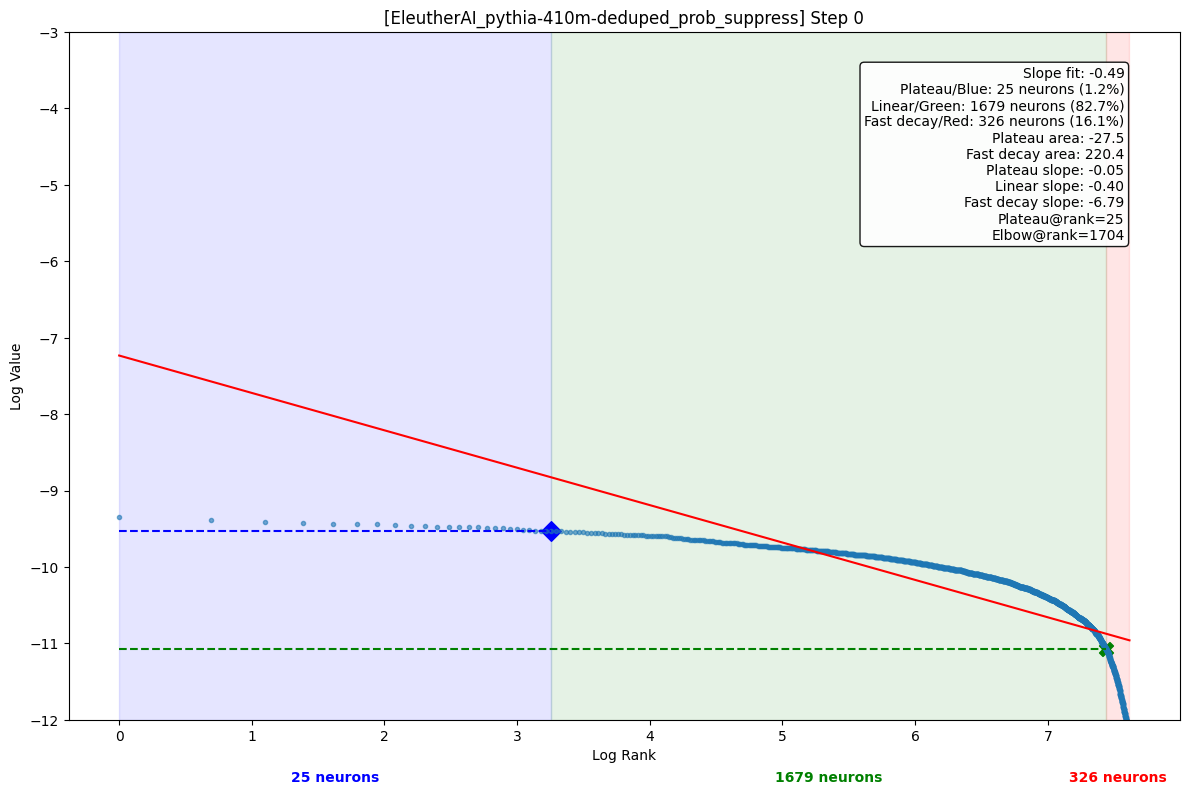

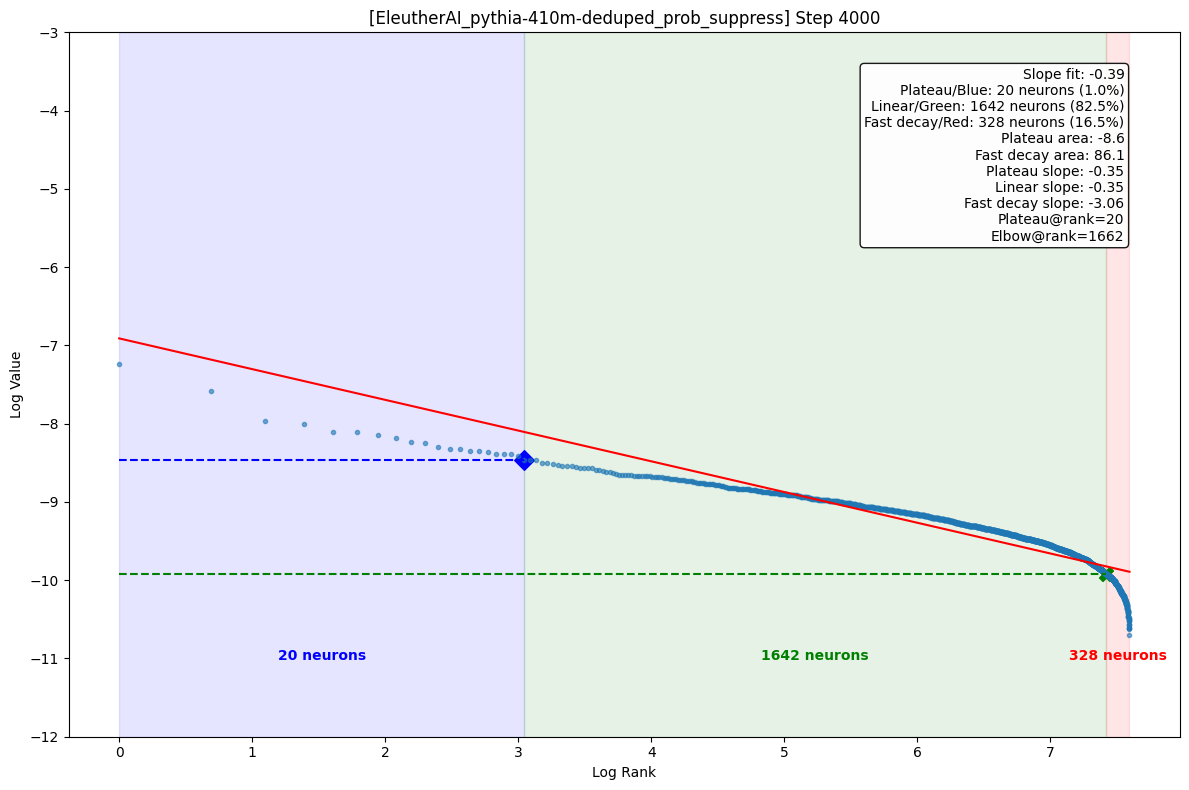

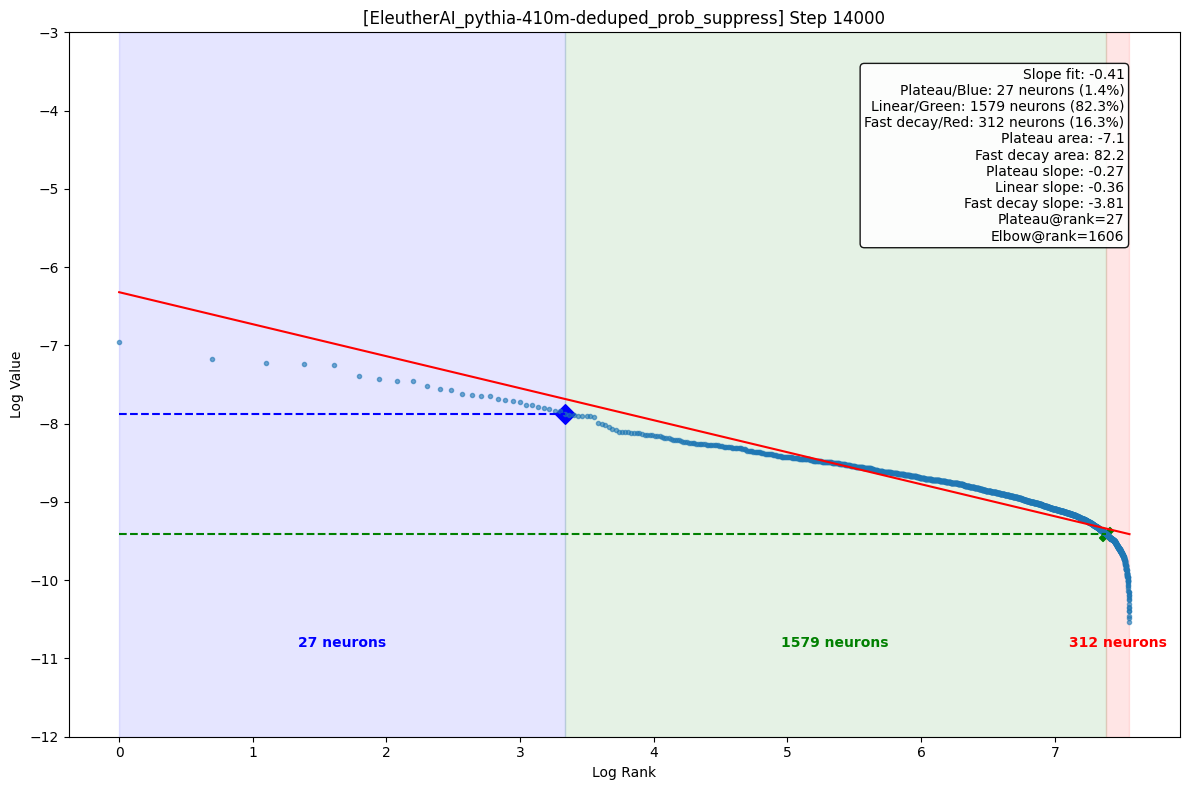

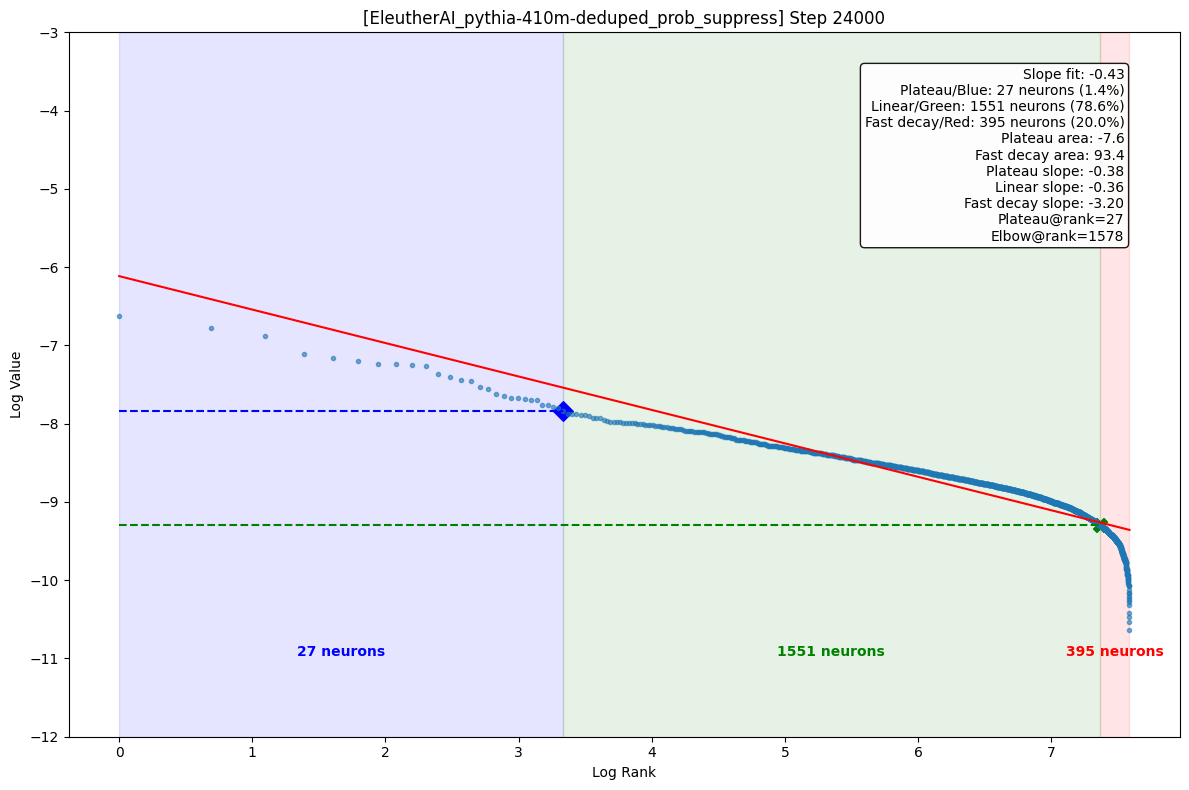

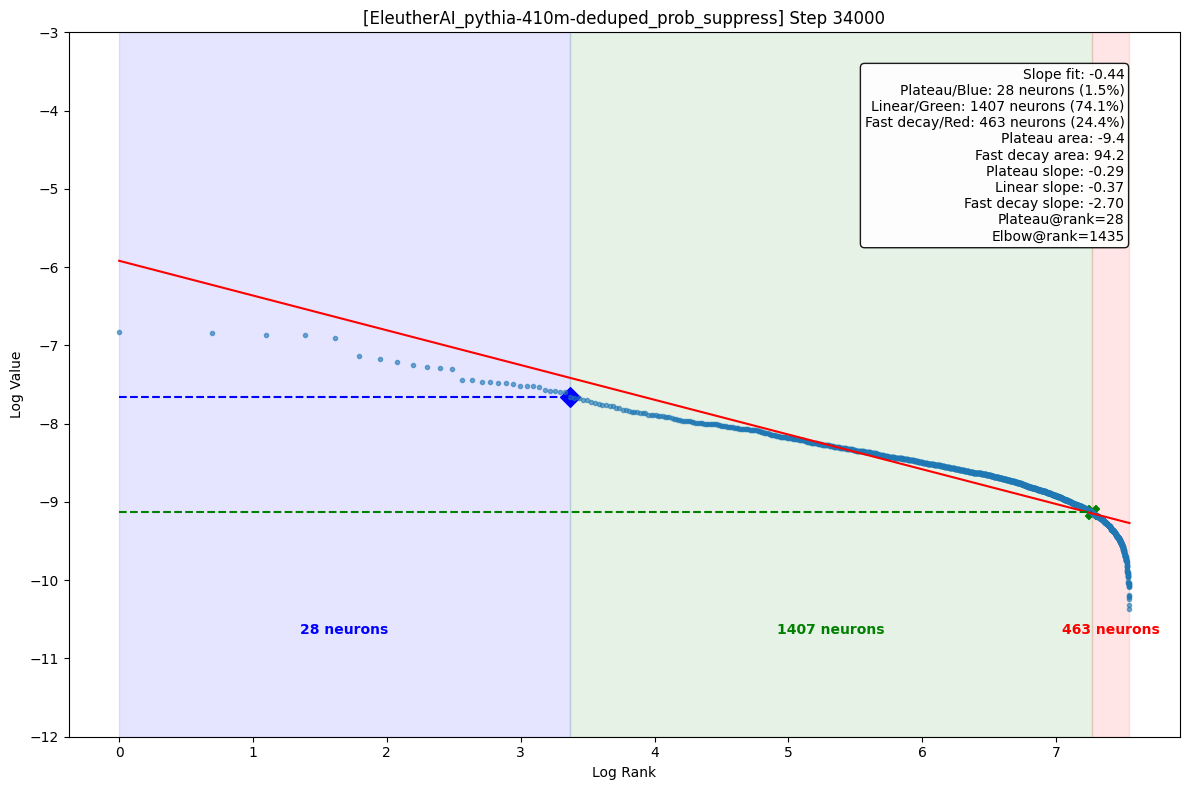

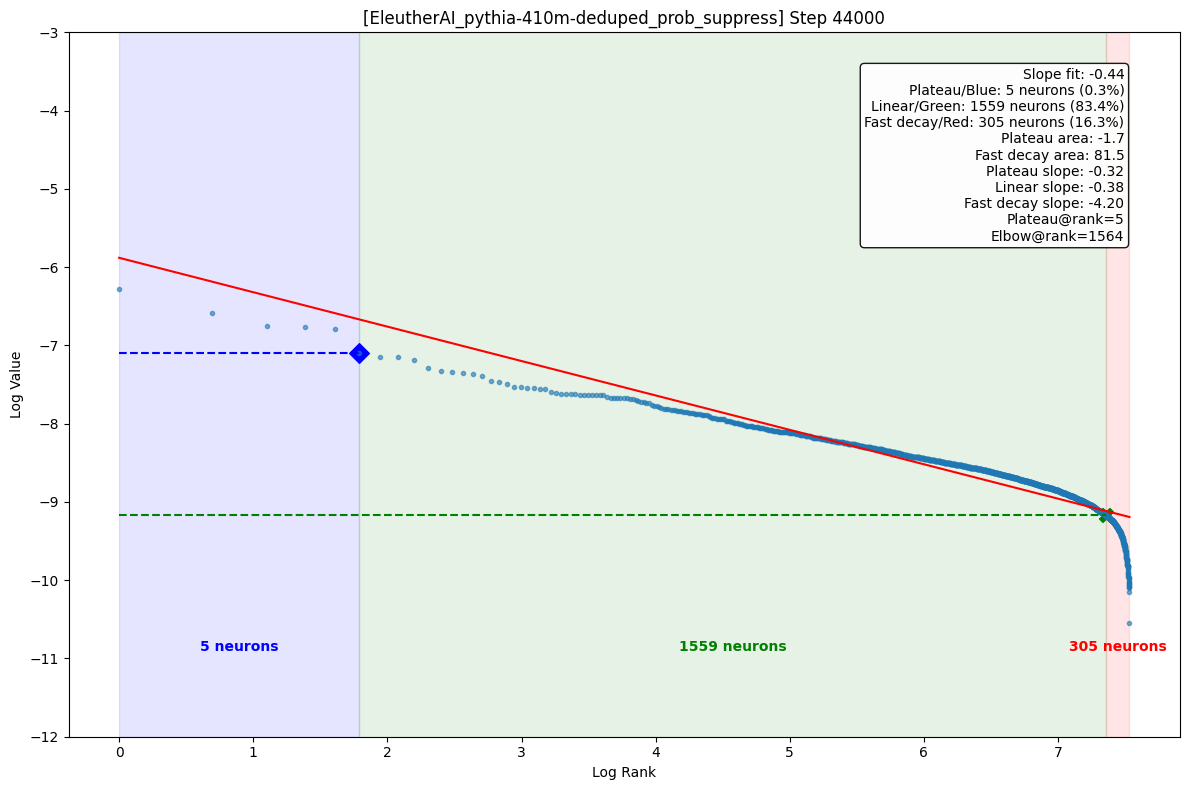

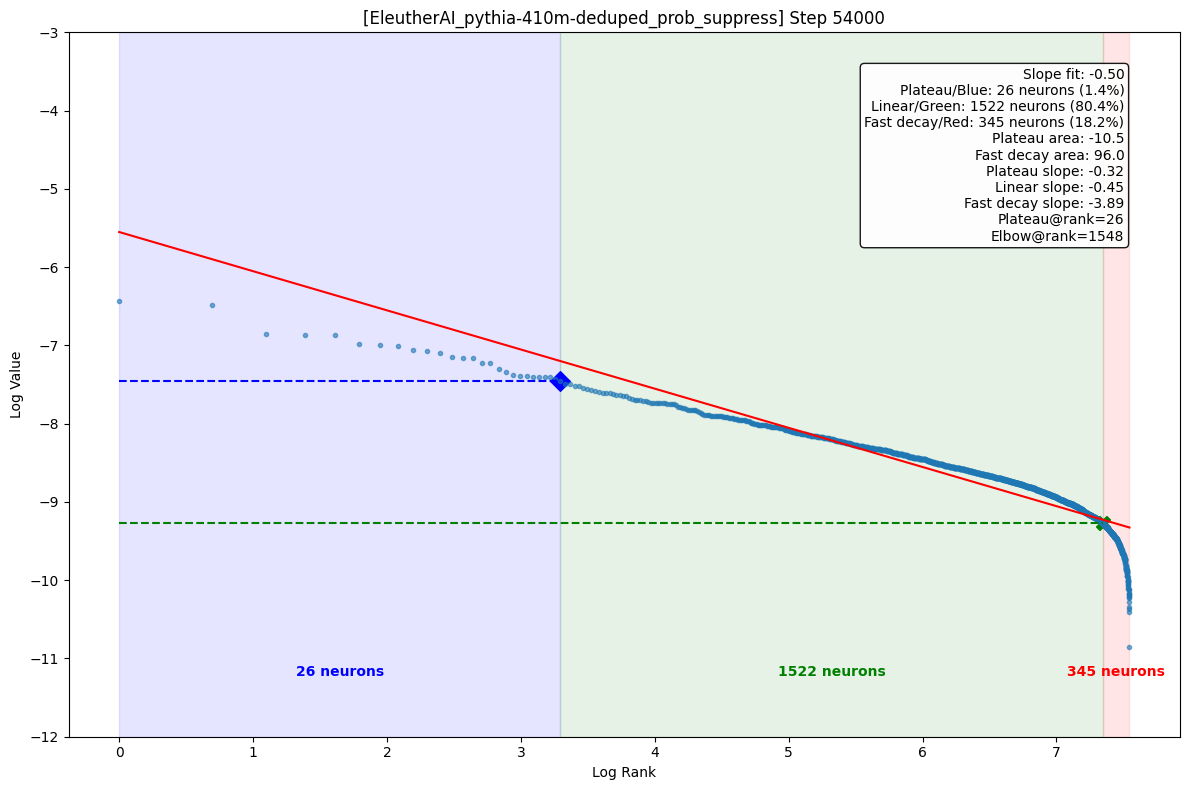

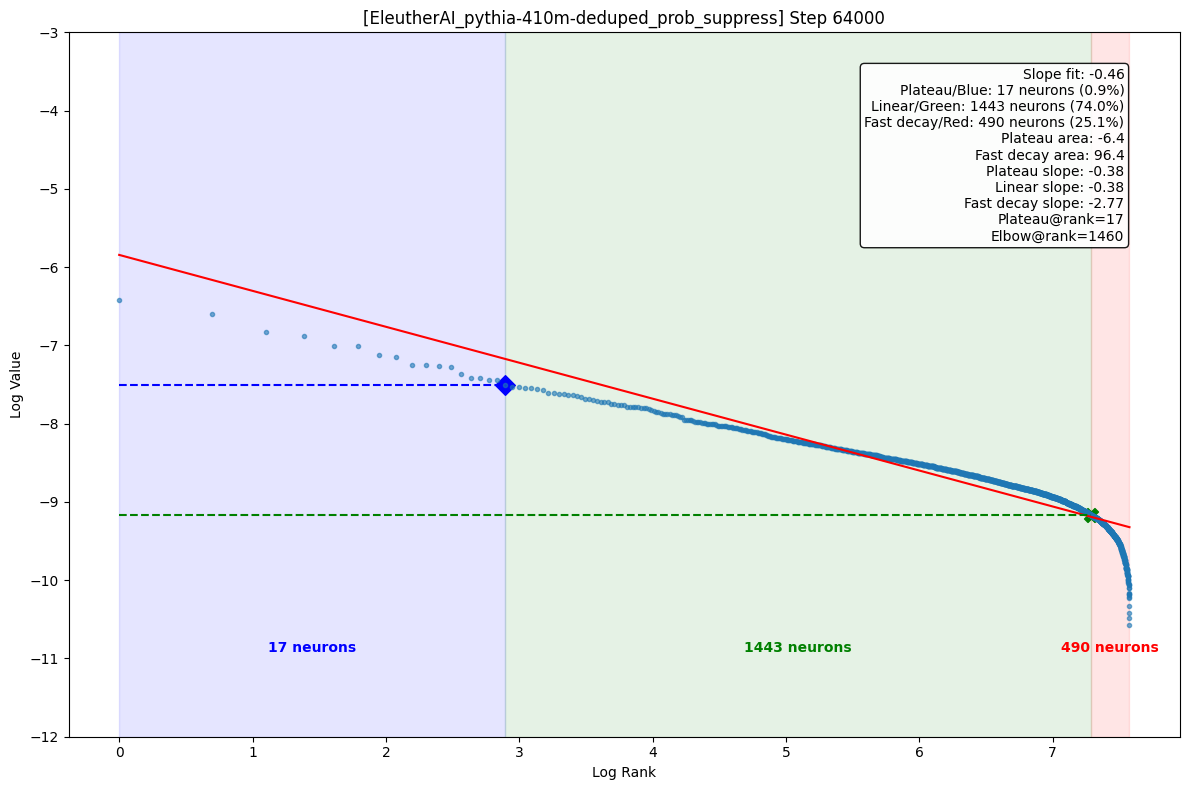

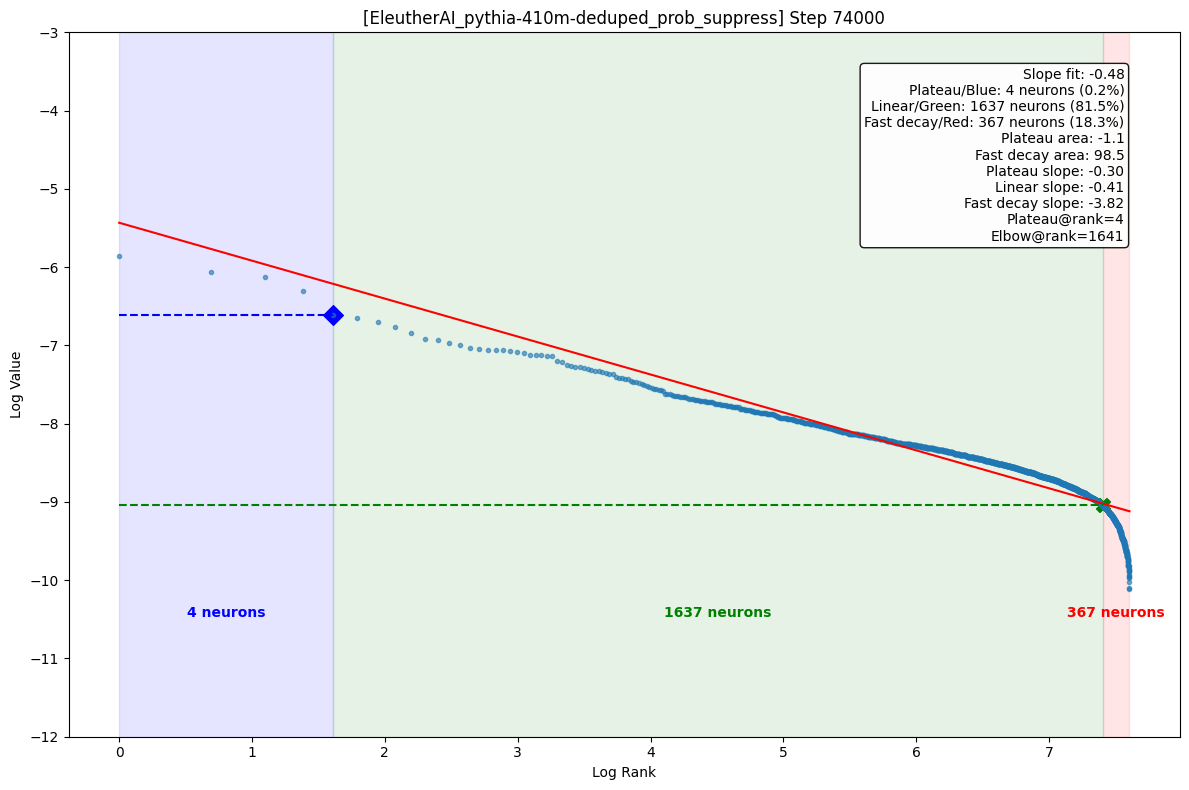

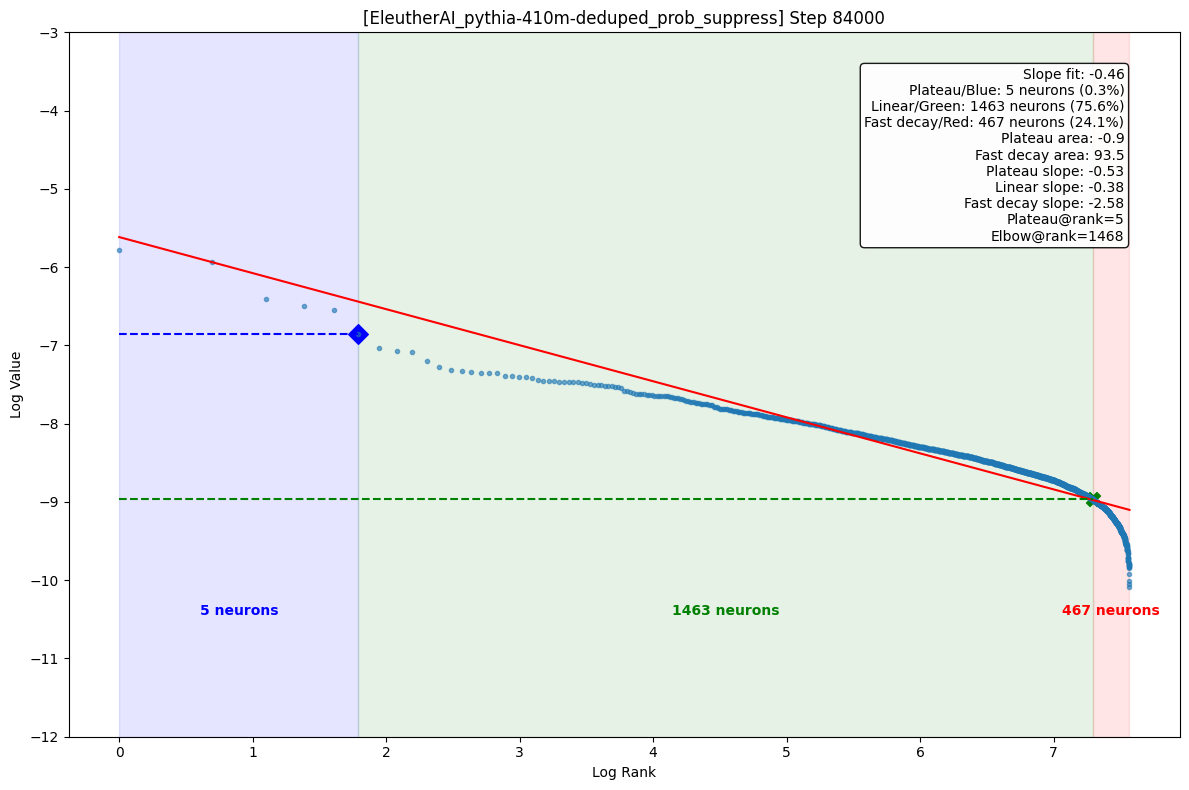

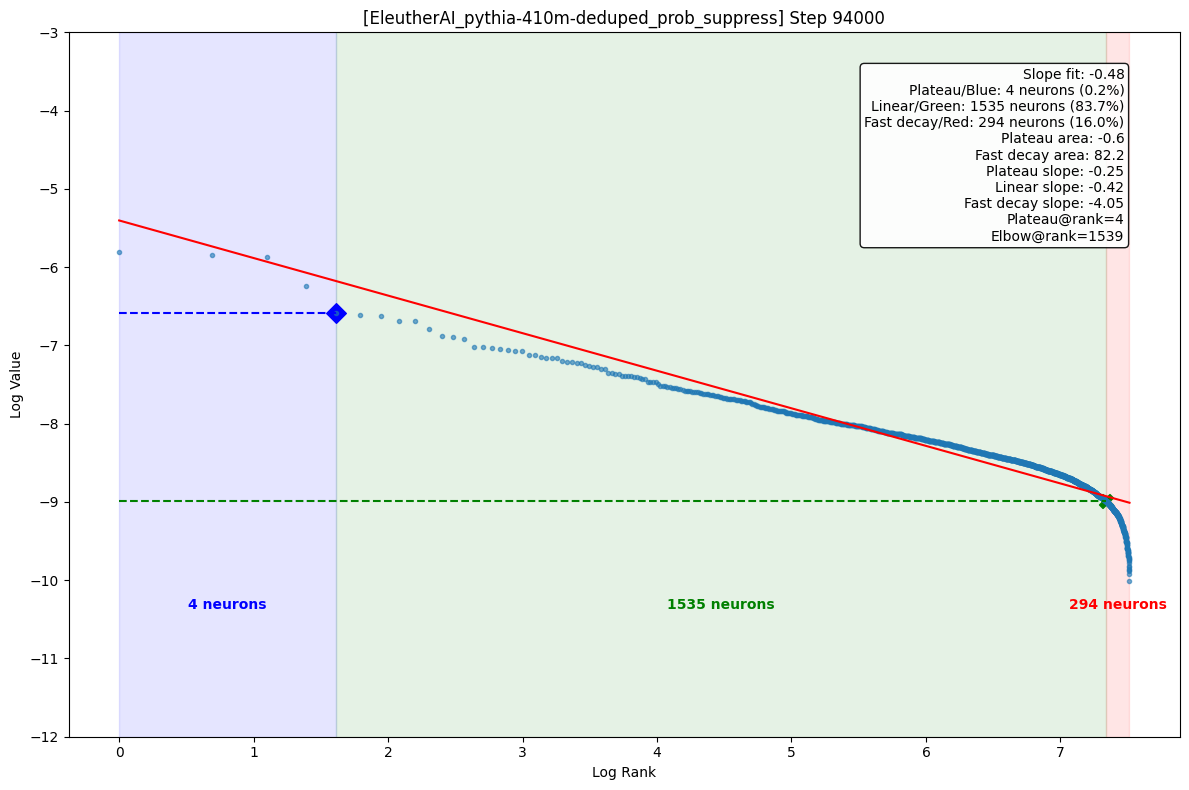

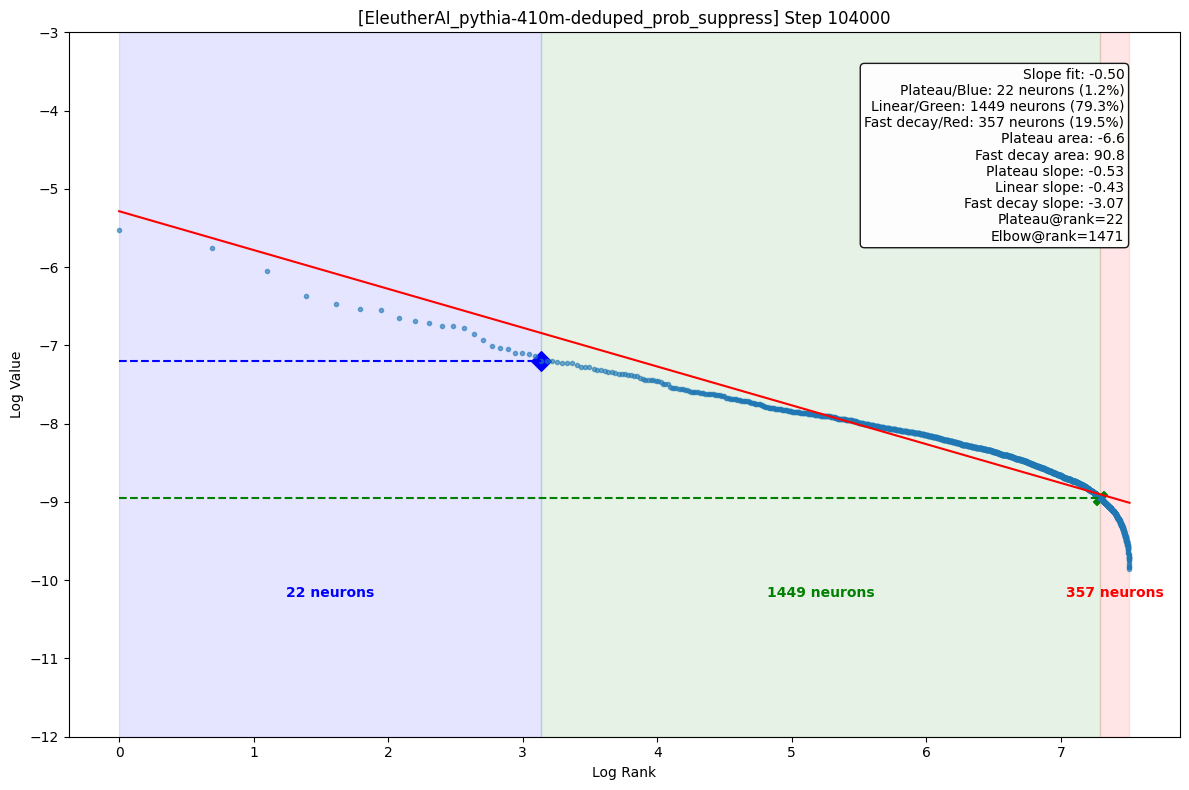

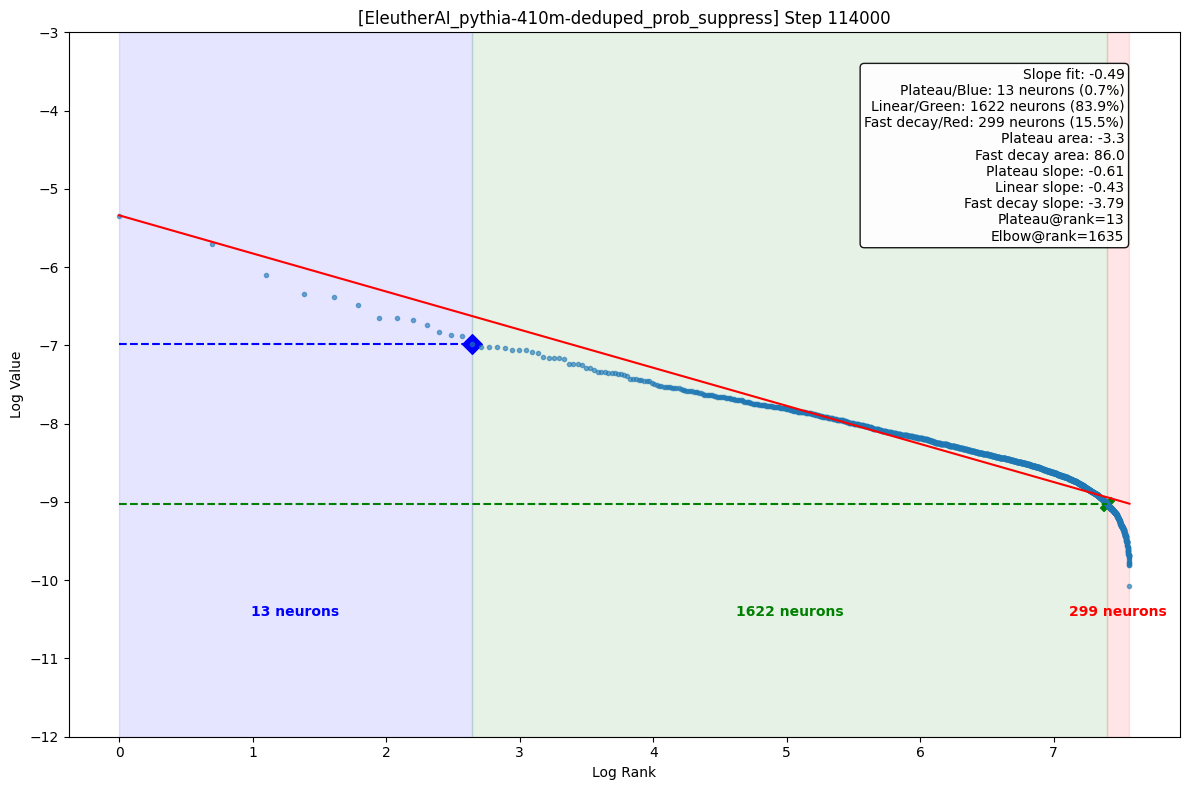

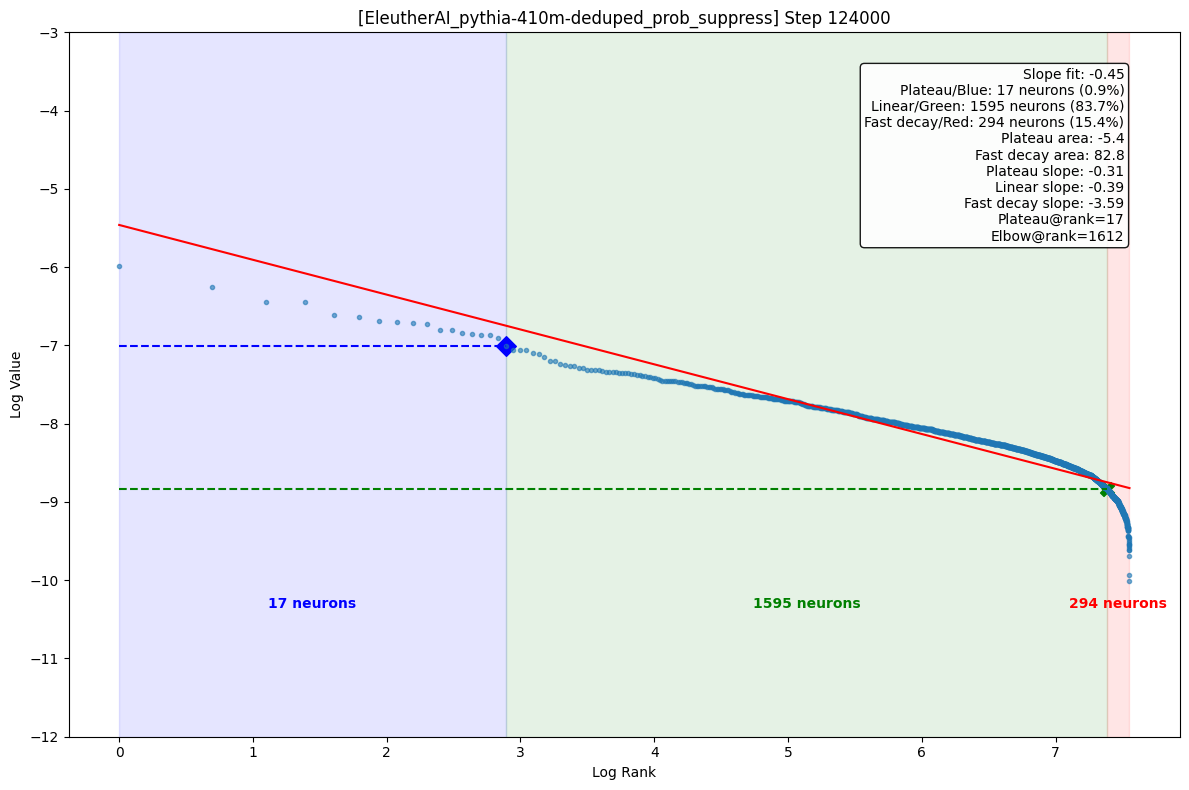

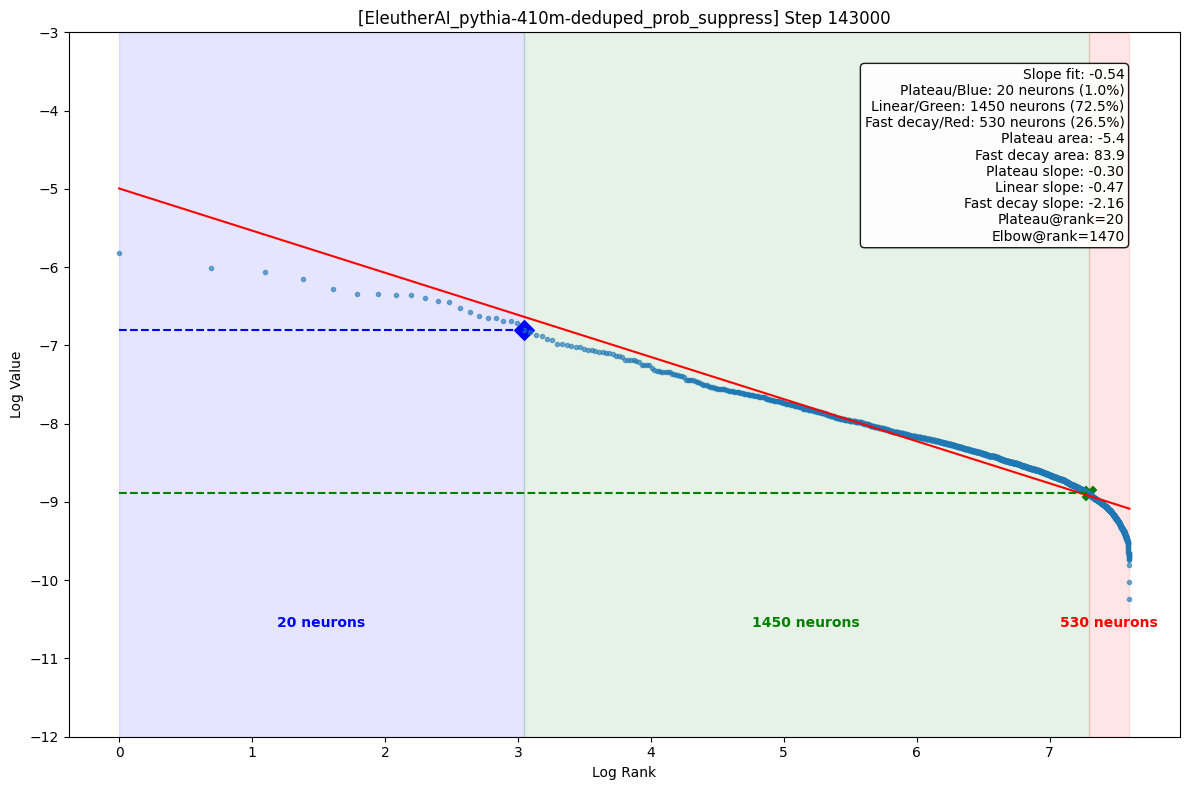

In [9]:
# Example usage:
optimized_plateau_params = {
   "window_size": 3,
   "threshold_multiplier": 0,
   "min_rank_percentile": 0.0,
   "max_log_rank": 3.5,
   "expected_direction": "positive"
}

optimized_elbow_params = {
   "window_size": 5,
   "threshold_multiplier": 0,
   "min_log_rank": 5.5,
   "max_log_rank": 7.5,
   "expected_direction": "negative"
}

file_metrics = run_analysis(
    root_dir=f"{ROOT_dir}/results/selection/neuron/longtail_50",
    output_dir=f"{ROOT_dir}/fig/delta_loss",
    plateau_params=optimized_plateau_params,
    elbow_params=optimized_elbow_params,
    ylim=(-12, -3)  # Consistent y-axis limits
)




## Quick check on first derivatives

In [15]:
# check derivatives by steps
# get rank and values

def rank_val(values)->tuple[np.array,np.array]:
    """Analyze the distribution and identify both transition points using a unified approach. """
    arr = np.array(values)
    arr = arr[arr > 0]
    sorted_vals = np.sort(arr)[::-1]
    ranks = np.arange(1, len(sorted_vals)+1)
    return np.log(ranks), np.log(sorted_vals)


def plot_slope(
    log_ranks: np.ndarray,
    log_vals: np.ndarray,
    window_size: int = 50,
) -> dict:
    """Get first derivatives of each step."""
    n = len(log_ranks)
    
    # Apply rank percentile constraints
    max_idx = min(int(len(log_ranks)), n - window_size)
    # Dynamic window size
    w = min(window_size, max(5, (max_idx - window_size) // 5))
    # Calculate first derivatives (slopes)
    derivatives, idxs = [], []
    for i in range(window_size, max_idx - w + 1):
        slope, _, _, _, _ = stats.linregress(
            log_ranks[i : i + w], log_vals[i : i + w]
        )
        derivatives.append(slope)
        idxs.append(i)
    derivatives = np.array(derivatives)
    return derivatives


def run_analysis(
    root_dir: str, 
    output_dir: str, 
    ylim: tuple = None,
    window_size: int = 50,
):
    """Batch process all 500_all.csv files in the directory,"""
    root_path = Path(root_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    
    # Find all CSV files
    csv_files = list(root_path.rglob("500_all.csv"))
    
    
    for csv_file in csv_files:
        # Read and preprocess the CSV
        df = pd.read_csv(csv_file)
        df["abs_delta_loss_post_ablation"] = df["abs_delta_loss_post_ablation"].apply(ast.literal_eval)
        df["step"] = df["step"].astype(str)
        rel_id = str(csv_file.relative_to(root_path).parent).replace("/", "_")
        
        
        # Analyze each training step
        for _, row in df.iterrows():
            vals = row["abs_delta_loss_post_ablation"]
            log_ranks, log_vals = rank_val(vals)
            derivatives = plot_slope(log_ranks, log_vals)
            plt.plot(log_ranks[:-window_size],derivatives)
            plt.show()
            
            # Apply the unified approach with custom parameters
            
            
            

In [62]:
def plot_slope(
    log_ranks: np.ndarray,
    log_vals: np.ndarray,
    window_size: int = 2,
) -> tuple[np.ndarray, np.ndarray]:
    """Get first derivatives of each step.
    
    Returns:
        tuple: (derivatives, indices) where derivatives are the slopes and 
               indices are the corresponding positions in the original array
    """
    n = len(log_ranks)
    # Apply rank percentile constraints
    max_idx = min(int(len(log_ranks)), n - window_size)
    # Dynamic window size
    w = min(window_size, max(5, (max_idx - window_size) // 5))

    # Calculate first derivatives (slopes)
    derivatives, idxs = [], []
    for i in range(window_size, max_idx - w + 1):
        slope, _, _, _, _ = stats.linregress(
            log_ranks[i : i + w*i], log_vals[i : i + w*i]
        )
        derivatives.append(slope)
        idxs.append(i)
    return np.array(derivatives), np.array(idxs)

def run_analysis(
    root_dir: str,
    output_dir: str,
    ylim: tuple = None,
    window_size = 5,
    step_lst = [],
):
    """Batch process all 500_all.csv files in the directory."""
    root_path = Path(root_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    # Find all CSV files
    csv_files = list(root_path.rglob("500_all.csv"))
    for csv_file in csv_files:
        # Read and preprocess the CSV
        df = pd.read_csv(csv_file)
        df["abs_delta_loss_post_ablation"] = df["abs_delta_loss_post_ablation"].apply(ast.literal_eval)
        df["step"] = df["step"].astype(str)
        rel_id = str(csv_file.relative_to(root_path).parent).replace("/", "_")
        
        # Analyze each training step
        
        for _, row in df.iterrows():
            vals = row["abs_delta_loss_post_ablation"]
            step = str(row["step"])
            log_ranks, log_vals = rank_val(vals)
            if step in step_lst:
                derivatives, idxs = plot_slope(log_ranks, log_vals, window_size)
                # Use the correct indices for plotting
                plt.plot(log_ranks[idxs], derivatives,label = step)
            
        plt.title(f"{rel_id}")
        plt.xlabel("Log rank")
        plt.ylabel("Slope")
        plt.ylim(ylim)
        plt.legend()
        plt.show()
        # Apply the unified approach with custom parameterswindow_size: int = 10,

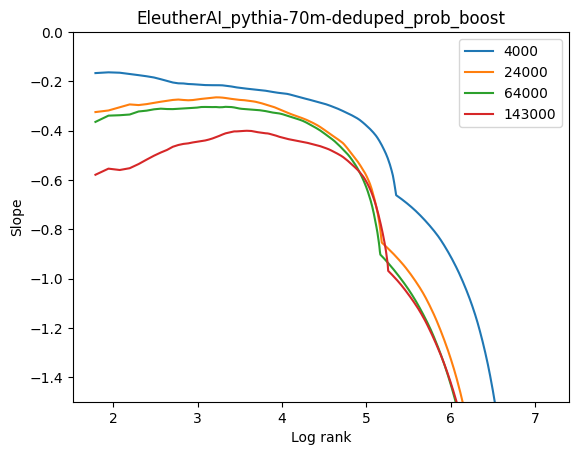

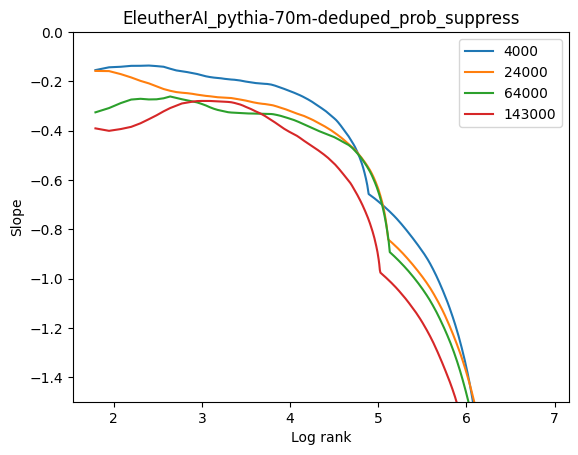

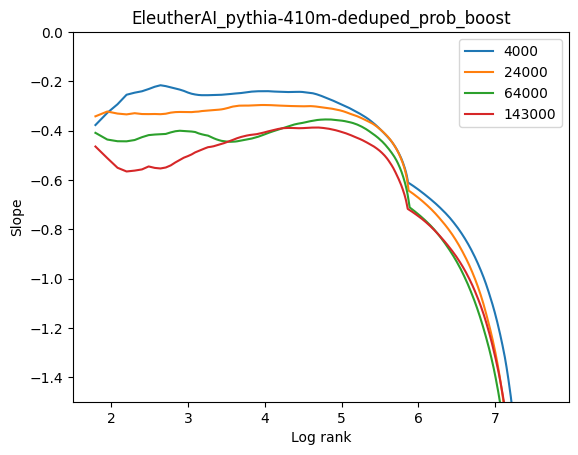

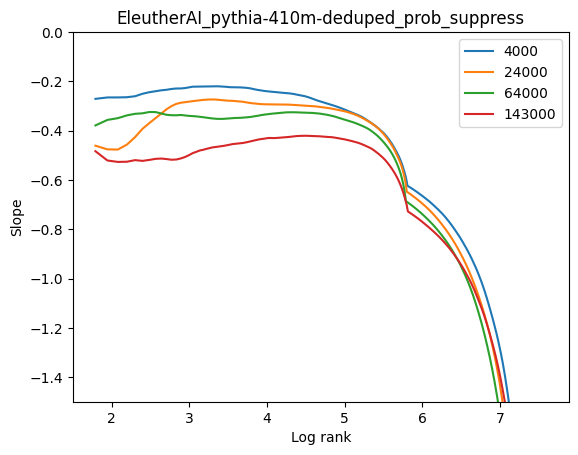

In [63]:
file_metrics = run_analysis(
    root_dir=f"{ROOT_dir}/results/selection/neuron/longtail_50",
    output_dir=f"{ROOT_dir}/fig/loss_slope",
    ylim=[-1.5,0],
    window_size = 5,
    step_lst = ["4000","24000", "64000","143000"]
)
